In [822]:
# Maths
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy.stats as stats
from scipy.stats import binom, norm
import math

# ARIMA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Gaussian Processes
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# Bayesian Stuff
import pymc as pm
import arviz as az

# Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
sns.set_style('whitegrid')

# Read in Norwegian EV Registration Data

In [823]:
df = pd.read_csv('../../data/vehicle_data/norway_vehicle_registrations.csv').dropna().set_index('Year', drop=False)
df['Year_Datetime'] = pd.to_datetime(df['Year'].astype(str), format='%Y')
df

Year  BEV_Stock  PHEV_Stock  EV_Stock  ICEV_Stock  Total_Stock  \
Year                                                                   
2009  2009       1388           0      1388   2311945.0    2313333.0   
2010  2010       1782           0      1782   2225718.0    2227500.0   
2011  2011       3982           1      3983   2338370.0    2342353.0   
2012  2012       6543         341      6884   2416449.0    2423333.0   
2013  2013      18000        3034     21034   2478966.0    2500000.0   
2014  2014      39000        7106     46106   2502914.0    2549020.0   
2015  2015      69000       33455    102455   2511181.0    2613636.0   
2016  2016      97532       34431    131963   2529636.0    2661599.0   
2017  2017     138983       67315    206298   2511668.0    2717966.0   
2018  2018     195351       96133    291484   2458957.0    2750441.0   
2019  2019     260692      116042    376734   2422919.0    2799653.0   
2020  2020     340002      146153    486155   2322785.0    2808940.0   
2021  2021     460734      184503    645237   2235405.0    2880642.0   
2022  2022     599169      198841    798010   2107570.0    2905580.0   

      BEV_Stock_Share_Total  PHEV_Stock_Share_Total  EV_Stock_Share_Total  \
Year                                                                        
2009                 0.0006                  0.0000                0.0006   
2010                 0.0008                  0.0000                0.0008   
2011                 0.0017                  0.0000                0.0017   
2012                 0.0027                  0.0001                0.0028   
2013                 0.0072                  0.0012                0.0084   
2014                 0.0153                  0.0028                0.0181   
2015                 0.0264                  0.0128                0.0392   
2016                 0.0366                  0.0130                0.0496   
2017                 0.0511                  0.0248                0.0759   
2018                 0.0710                  0.0349                0.1059   
2019                 0.0931                  0.0414                0.1345   
2020                 0.1171                  0.0411                0.1582   
2021                 0.1550                  0.0591                0.2141   
2022                 0.1676                  0.0614                0.2290   

      ICEV_Stock_Share_Total  ...  EV_New_Registrations  \
Year                          ...                         
2009                  0.9994  ...                   145   
2010                  0.9992  ...                   380   
2011                  0.9983  ...                  2010   
2012                  0.9972  ...                  4596   
2013                  0.9916  ...                  8364   
2014                  0.9819  ...                 19697   
2015                  0.9608  ...                 33408   
2016                  0.9504  ...                 44530   
2017                  0.9241  ...                 61980   
2018                  0.8941  ...                 72650   
2019                  0.8655  ...                 88873   
2020                  0.8418  ...                112789   
2021                  0.7859  ...                164618   
2022                  0.7710  ...                169094   

      ICEV_New_Registrations  Total_New_Registrations  \
Year                                                    
2009                131673.0                 131818.0   
2010                126287.0                 126667.0   
2011                136542.0                 138552.0   
2012                133586.0                 138182.0   
2013                141636.0                 150000.0   
2014                130295.0                 149992.0   
2015                125195.0                 158603.0   
2016                115833.0                 160363.0   
2017                105722.0                 167702.0   
2018                 86189.0                 158

# "Global" Variables

In [900]:
t_max = 2016
horizon = 2030

icev_ban = 2025
phev_ban = 2025

RANDOM_SEED = 42

n_sim = 1000

# Sales Share Projection with Gaussian Processes

- NOTE: I need to play with different choices of kernels to choose the best one for this task.

- In addition, I need to change my prior for the mean to better reflect the expected trend between the most recent point and the future point.

### Add Projected Datapoint at the ICEV and PHEV Ban Date

In [901]:
def project_sales_share(df, ban, value_at_ban):
    
    date_range = np.arange(df.index.values[0], horizon+1) # Current and Future Dates
    df = df.reindex(date_range)

    # Linear Interpolation
    df.loc[ban:] = value_at_ban # 0 if banned vehicle type, 1 if beneficiary.
    return df

### Function to Train Sales Share GP

In [902]:
def train_sales_share_gp(df, ban_date):

    """
    Trains a Gaussian Process Regressor model.

    Parameters:
    df (DataFrame): The input data containing market share values over time.
    ban_date (int): The year from which certain vehicles are banned (assumed as start of projection).

    Returns:
    gaussian_process (GaussianProcessRegressor): A trained Gaussian Process Regressor model.
    """

    # Combine historical data up to t_max with post-ban dates
    dates = np.append(df.loc[:t_max].index.values, [ban_date])

    # Prepare training data
    X_train = dates.reshape(-1, 1)
    y_train = df.loc[dates].values.reshape(-1, 1)

    # Define the kernel (you can adjust kernel parameters)
    k1 = 1 * RBF(length_scale=10, length_scale_bounds=(1e-15, 1e3))
    k2 = 1 * RBF(length_scale=1, length_scale_bounds=(1e-15, 1e3))
    k3 = WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-15, 1e+1))

    # Combine Kernels
    kernel = k1 + k3

    # Create GaussianProcessRegressor with defined kernel
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, normalize_y=True)

    # Fit the Gaussian process to the training data
    gaussian_process.fit(X_train, y_train)

    # Return the trained Gaussian Process Regressor model
    return gaussian_process

### Function to plot Sales Share GP

In [903]:
def plot_sales_share_gp(gp, data_x, data_y, title):

    X = np.arange(2009, horizon+1, 0.1).reshape(-1,1)

    mean_stock_prediction, std_prediction = gp.predict(X, return_std=True)
    
    plt.fill_between(
        X.ravel(),
        mean_stock_prediction - 2.576 * std_prediction,
        mean_stock_prediction + 2.576 * std_prediction,
        alpha=0.1,
        color='green',
        label=r"99% confidence interval",
    )
    plt.fill_between(
        X.ravel(),
        mean_stock_prediction - 1.96 * std_prediction,
        mean_stock_prediction + 1.96 * std_prediction,
        alpha=0.3,
        color='green',
        label=r"95% confidence interval",
    )
    plt.fill_between(
        X.ravel(),
        mean_stock_prediction - 1 * std_prediction,
        mean_stock_prediction + 1 * std_prediction,
        alpha=0.5,
        color='green',
        label=r"68% confidence interval",
    )

    plt.scatter(data_x[:t_max+1-2009], data_y[:t_max+1-2009], label='Historical Sales Share (Seen)')
    plt.scatter(data_x[t_max+1-2009:], data_y[t_max+1-2009:], label='Historical Sales Share (Unseen)', color='purple')
    plt.plot(X, mean_stock_prediction, label="Mean prediction", color='black')

    plt.legend()
    plt.xlabel("$x$")
    plt.ylabel("$f(x)$")
    plt.title(title)
    plt.show()

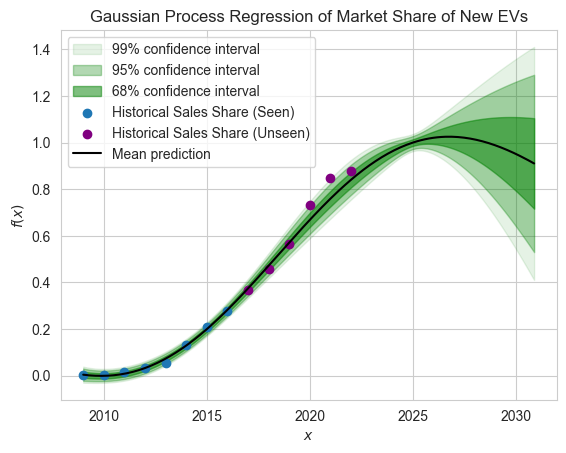

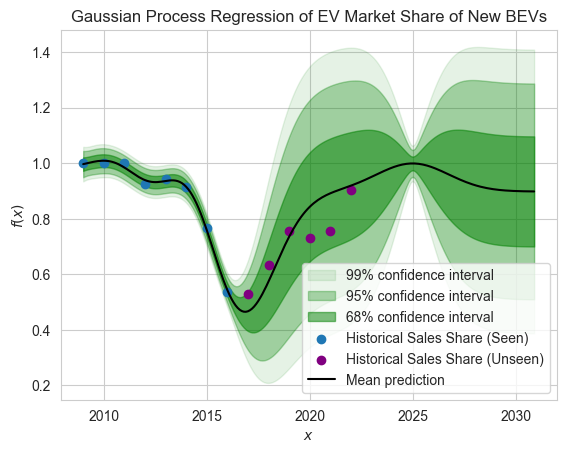

In [904]:
ev_sales_share = project_sales_share(df.loc[:t_max, 'EV_Market_Share_New_Registrations'], icev_ban, 1)
bev_sales_share = project_sales_share(df.loc[:t_max, 'BEV_Market_Share_New_EV_Registrations'], phev_ban, 1)

ev_share_gp = train_sales_share_gp(ev_sales_share, icev_ban)
bev_share_gp = train_sales_share_gp(bev_sales_share, phev_ban)

plot_sales_share_gp(
    ev_share_gp, 
    df.index.values, 
    df['EV_Market_Share_New_Registrations'].values.reshape(-1, 1), 
    'Gaussian Process Regression of Market Share of New EVs'
)

plot_sales_share_gp(
    bev_share_gp, 
    df.index.values, 
    df['BEV_Market_Share_New_EV_Registrations'].values.reshape(-1, 1), 
    'Gaussian Process Regression of EV Market Share of New BEVs'
)

### Truncating and Sampling from GP
To avoid sales shares gong above 1 or below 0.

In [905]:
def truncate_and_sample_gp(gaussian_process, n_sim, ban_date):

    X = np.arange(t_max, horizon + 1).reshape(-1,1)
    
    mean_stock_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

    a = - mean_stock_prediction/std_prediction # Lower Limit for Projections. The multiples of std can't go lower than this!
    b = (1 - mean_stock_prediction)/std_prediction # Upper Limit for Projections. The multiples of std can't go higher than this!

    gp_truncated = np.zeros([len(X), n_sim])
    
    for i in range(0, len(X)):
        gp_truncated[i] = mean_stock_prediction[i] + std_prediction[i]*np.sort(stats.truncnorm.ppf(np.random.rand(n_sim), a[i], b[i])) # Percentile Point Function
    
    gp_truncated_df = pd.DataFrame(index=np.arange(t_max, horizon + 1), columns=range(0, n_sim), data=gp_truncated)

    gp_truncated_df.loc[ban_date:] = 1
    
    return gp_truncated_df

<Axes: title={'center': 'PHEV Share GP Regression Samples'}>

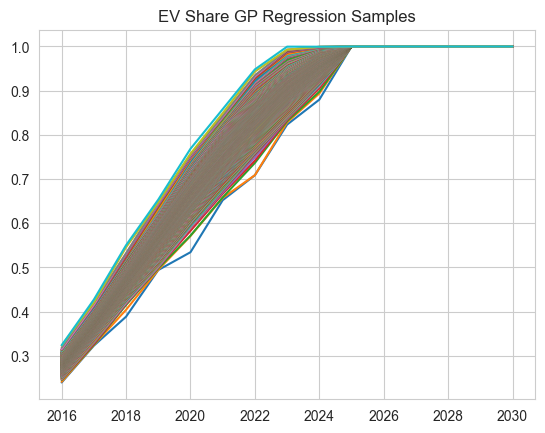

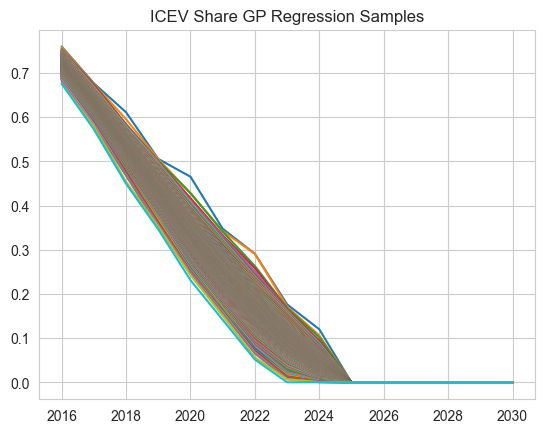

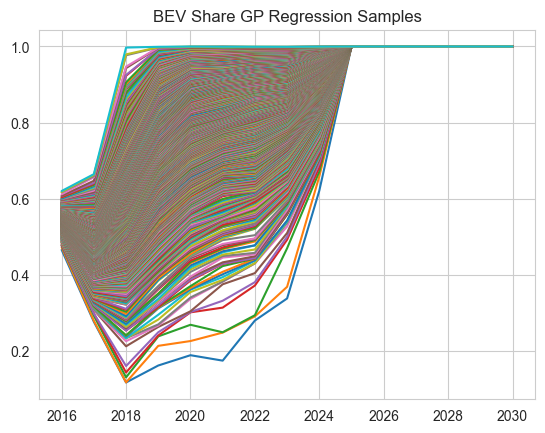

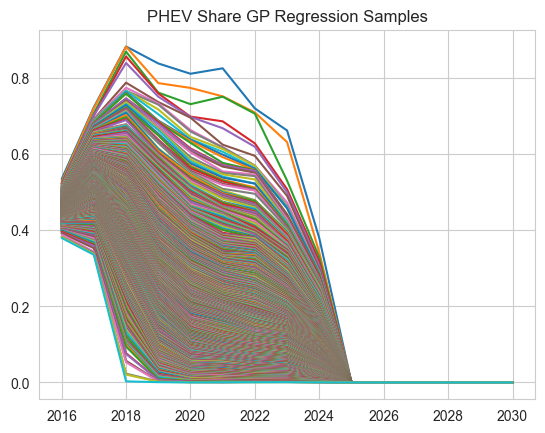

In [906]:
ev_share_gp_samples = truncate_and_sample_gp(ev_share_gp, n_sim, icev_ban)
bev_share_gp_samples = truncate_and_sample_gp(bev_share_gp, n_sim, phev_ban)

icev_share_gp_samples = 1 - ev_share_gp_samples
phev_share_gp_samples = 1 - bev_share_gp_samples

ev_share_gp_samples.plot(legend=False, title='EV Share GP Regression Samples')
icev_share_gp_samples.plot(legend=False, title='ICEV Share GP Regression Samples')
bev_share_gp_samples.plot(legend=False, title='BEV Share GP Regression Samples')
phev_share_gp_samples.plot(legend=False, title='PHEV Share GP Regression Samples')

# Modelling New Vehicle Registrations using an ARIMA Model

Text(0.5, 1.0, 'Historical Total New Vehicle Registrations')

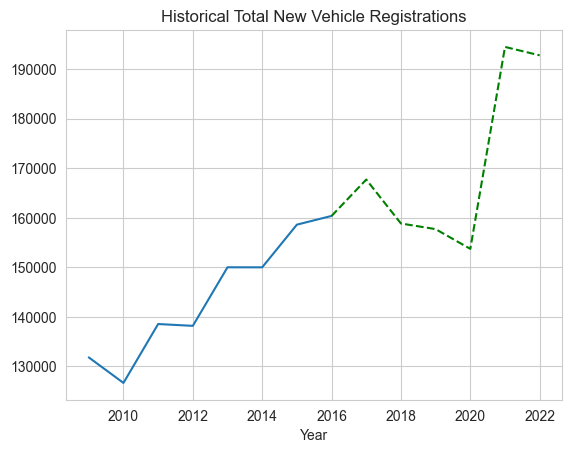

In [907]:
fig, ax = plt.subplots()
df.loc[:t_max, 'Total_New_Registrations'].plot(ax=ax, label='Historical Train')
df.loc[t_max:, 'Total_New_Registrations'].plot(ax=ax, color='green', linestyle='--', label='Historical Test')
plt.title('Historical Total New Vehicle Registrations')

### Train ARIMA Model on Historical Vehicle Stock Data

In [908]:
def train_ARIMA_model(endog, dates):
    # Fit ARIMA model
    model = ARIMA(endog=endog, dates=dates, order=(2, 1, 2))  # Probably need to tune these values
    model_fit = model.fit()

    # Forecast
    forecast_steps = horizon-t_max  # Number of years to forecast

    # Get forecast and associated confidence intervals
    forecast = model_fit.get_forecast(steps=forecast_steps)
    forecast_mean = forecast.predicted_mean
    forecast_std = np.sqrt(forecast.var_pred_mean) # Standard deviations from the forecast

    # Add values at time = t_max (Last bit of training data)
    forecast_mean = np.insert(forecast_mean, obj=0, values=endog[-1])
    forecast_std = np.insert(forecast_std, obj=0, values=0)

    return forecast_mean, forecast_std

In [909]:
(df.loc[:t_max, 'Total_New_Registrations']/df.loc[:t_max, 'Total_Stock']).values

array([0.05698185, 0.0568651 , 0.05915078, 0.05702147, 0.06      ,
       0.05884301, 0.0606829 , 0.06025062])

In [910]:
forecast_mean, forecast_std = train_ARIMA_model(
    endog=(df.loc[:t_max, 'Total_New_Registrations']/df.loc[:t_max, 'Total_Stock']).values, 
    dates=df.loc[:t_max, 'Year_Datetime'].values
)

/Users/isaacflower/miniconda3/envs/probabilistic_ev_demand_modelling/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/isaacflower/miniconda3/envs/probabilistic_ev_demand_modelling/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


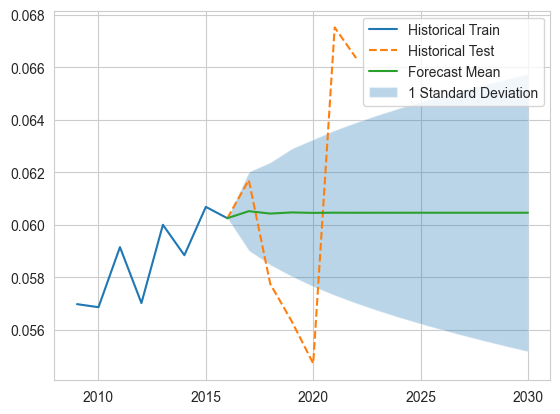

In [911]:
fig, ax = plt.subplots()

ax.plot(
    df.loc[:t_max, 'Total_New_Registrations'].index.values, 
    (df.loc[:t_max, 'Total_New_Registrations']/df.loc[:t_max, 'Total_Stock']).values, 
    label='Historical Train'
)

ax.plot(
    df.loc[t_max:, 'Total_New_Registrations'].index.values, 
    (df.loc[t_max:, 'Total_New_Registrations']/df.loc[t_max:, 'Total_Stock']).values, 
    linestyle='--', 
    label='Historical Test'
)

ax.plot(
    np.arange(t_max, horizon+1), 
    forecast_mean, 
    label='Forecast Mean'
)

ax.fill_between(
    np.arange(t_max, horizon+1), 
    forecast_mean - forecast_std, 
    forecast_mean + forecast_std, 
    label='1 Standard Deviation', 
    alpha=0.3
)

plt.legend()

plt.show()

### Producing `n_sim` Scenarios

In [912]:
def simulate_baseline_registration_rates(forecast_mean, forecast_std, n_sim):
    # Sample possible values for each forecasted year
    r_reg_samples = []

    for mean, std in zip(forecast_mean, forecast_std):
        # Sample random errors from a normal distribution based on forecast std
        random_errors = np.random.normal(loc=0, scale=std, size=n_sim)
        
        # Generate sampled values by adding random errors to the forecasted mean
        samples = mean + random_errors
        
        # Append sampled values to the list
        r_reg_samples.append(samples)

    # Convert sampled values list to a numpy array
    r_reg_samples = np.array(r_reg_samples)

    r_reg_baseline_df = pd.DataFrame(index=np.arange(t_max, horizon+1), columns=range(0, n_sim), data=r_reg_samples)

    r_reg_baseline_df.values.sort(axis=1)

    return r_reg_baseline_df

<Axes: >

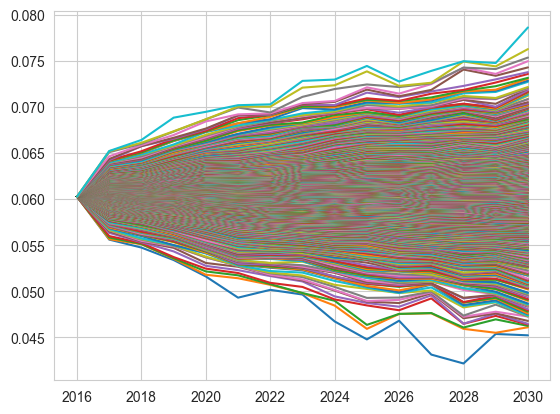

In [913]:
simulate_baseline_registration_rates(forecast_mean, forecast_std, n_sim).plot(legend=False)

# Modelling Vehicle Stock

In [914]:
def train_stock_gp(df, current_year, horizon, growth):

    """
    Trains a Gaussian Process Regressor model.

    Parameters:
    df (DataFrame): The input data containing market share values over time.
    ban_date (int): The year from which certain vehicles are banned (assumed as start of projection).

    Returns:
    gaussian_process (GaussianProcessRegressor): A trained Gaussian Process Regressor model.
    """

    # For when the total number of vehicle stays the same. memory = 1 ensures the widest uncertainty bands.
    memory = 1
    if (growth >= 0.95 and growth <= 1.05): 
        memory = 2

    # Combine historical data up to t_max with post-ban dates
    dates = np.append(df.loc[current_year-memory:current_year].index.values, horizon) # Use previous 2 data points

    # Prepare training data
    X_train = dates.reshape(-1, 1)
    y_train = df.loc[dates].values.reshape(-1, 1)

    # Define the kernel (you can adjust kernel parameters)
    k1 = 1 * RBF(length_scale=10, length_scale_bounds=(1e-2, 1e3)) # Longer Trends
    k2 = 1 * RBF(length_scale=0.1, length_scale_bounds=(1e-15, 1e3)) # Shorter Trends
    k3 = WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-15, 1e+1))

    # Combine Kernels
    kernel = k1 + k2 + k3

    # Create GaussianProcessRegressor with defined kernel
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, normalize_y=True)

    # Fit the Gaussian process to the training data
    gaussian_process.fit(X_train, y_train)

    # Return the trained Gaussian Process Regressor model
    return gaussian_process

In [915]:
def plot_stock_gp(gp, first_year, horizon, data_x, data_y, title):

    X = np.arange(first_year, horizon+1, 0.1).reshape(-1,1)

    mean_stock_prediction, std_prediction = gp.predict(X, return_std=True)
    
    plt.scatter(data_x, data_y, label='Historical Vehicles')
    plt.plot(X, mean_stock_prediction, label="Mean prediction", color='black')
    plt.fill_between(
        X.ravel(),
        mean_stock_prediction - 1.96 * std_prediction,
        mean_stock_prediction + 1.96 * std_prediction,
        alpha=0.5,
        color='green',
        label=r"95% confidence interval",
    )
    plt.fill_between(
        X.ravel(),
        mean_stock_prediction - 1 * std_prediction,
        mean_stock_prediction + 1 * std_prediction,
        alpha=0.7,
        color='green',
        label=r"68% confidence interval",
    )
    plt.legend()
    plt.xlabel("$x$")
    plt.ylabel("$f(x)$")
    plt.title(title)

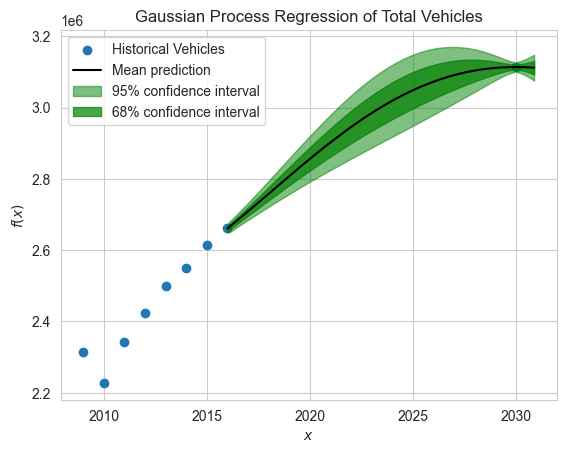

In [916]:
growth = 1.17 # The relative size of the vehicle stock at some future date

historical_vehicles = df.loc[:t_max, 'Total_Stock']
historical_vehicles[horizon] = historical_vehicles[t_max]*growth

historical_vehicles_gp = train_stock_gp(
    historical_vehicles, 
    t_max, 
    horizon,
    growth
)

plot_stock_gp(
    gp=historical_vehicles_gp, 
    first_year = t_max, 
    horizon = horizon, 
    data_x=historical_vehicles.index.values, 
    data_y=historical_vehicles.values.reshape(-1, 1), 
    title='Gaussian Process Regression of Total Vehicles',
)

# Add Shape to Registrations and Retirements

In [917]:
X = np.arange(t_max, horizon+1, 1).reshape(-1,1)

# Sample from vehicle stock GP predictions
stock_prediction_df = pd.DataFrame(
    index=np.arange(t_max, horizon+1), 
    columns=range(0, n_sim), 
    data=historical_vehicles_gp.sample_y(X, n_samples=n_sim)
)

<Axes: >

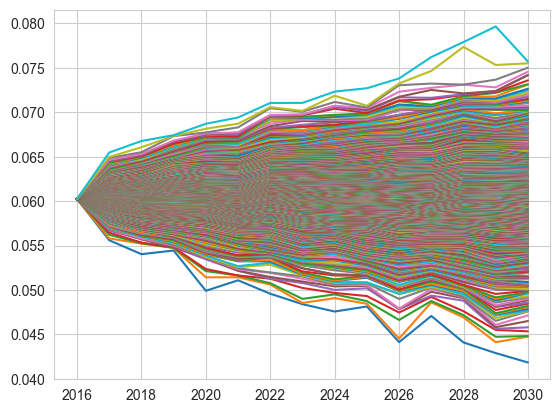

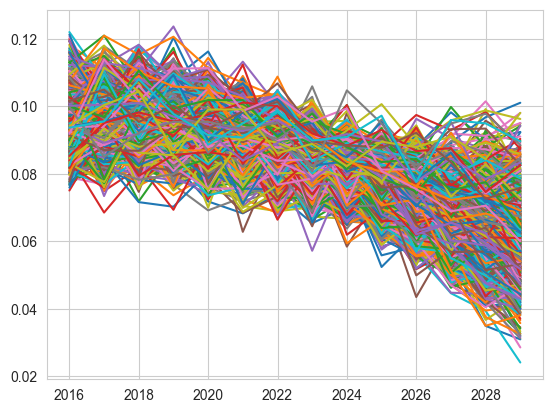

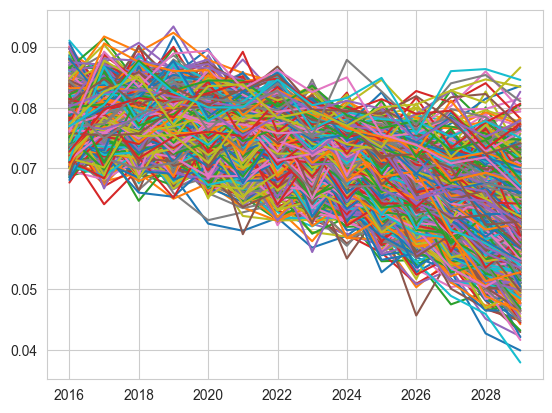

In [920]:
r_reg_baseline_df = simulate_baseline_registration_rates(forecast_mean, forecast_std, n_sim)

difference_df = stock_prediction_df.diff(1).shift(-1).div(stock_prediction_df).head(-1)

w = 2

r_ret_df = r_reg_baseline_df.sub((1-w)*difference_df, axis=0)
r_reg_df = r_reg_baseline_df.add(w*difference_df, axis=0).sub(r_ret_df[r_ret_df < 0].fillna(0)) # To make up for difference in registration rates that drop below 0.

r_ret_df[r_ret_df < 0] = 0 # To prevent negative retirement rates

r_reg_baseline_df.plot(legend=False)
r_reg_df.plot(legend=False)
r_ret_df.plot(legend=False)

<Axes: >

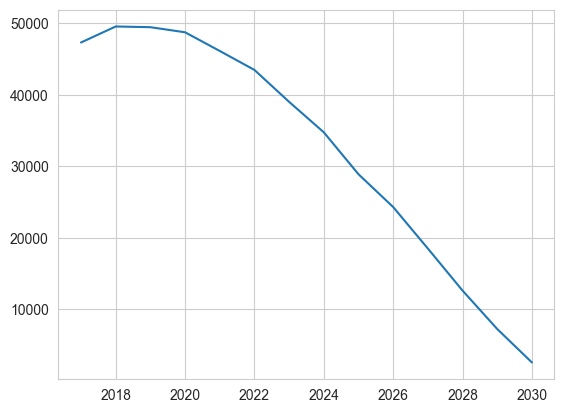

In [1188]:
difference_df.mean(axis=1).plot()

In [1140]:
r_reg_baseline_df

0         1         2         3         4         5         6    \
2016  0.060251  0.060251  0.060251  0.060251  0.060251  0.060251  0.060251   
2017  0.055998  0.056010  0.056369  0.056474  0.056607  0.056655  0.056709   
2018  0.054387  0.054577  0.055122  0.055270  0.055297  0.055442  0.055455   
2019  0.052474  0.053116  0.054211  0.054483  0.054557  0.054714  0.054780   
2020  0.052281  0.052558  0.052699  0.052713  0.053300  0.053316  0.053319   
2021  0.050642  0.050791  0.050962  0.050977  0.051380  0.052074  0.052942   
2022  0.049299  0.050509  0.051795  0.051849  0.052346  0.052401  0.052403   
2023  0.049064  0.049408  0.049441  0.049965  0.050938  0.051164  0.051589   
2024  0.046404  0.046548  0.047582  0.048981  0.049439  0.049836  0.049849   
2025  0.047919  0.048139  0.048746  0.048971  0.049402  0.049912  0.050370   
2026  0.045202  0.046849  0.047605  0.048246  0.048309  0.048662  0.048773   
2027  0.045635  0.046969  0.047268  0.047882  0.048021  0.048111  0.048216   
2028  0.044975  0.046252  0.046293  0.046565  0.046859  0.047028  0.047268   
2029  0.046307  0.046348  0.046440  0.046470  0.047205  0.047246  0.048143   
2030  0.040888  0.045744  0.045836  0.046500  0.047044  0.047235  0.047334   

           7         8         9    ...       990       991       992  \
2016  0.060251  0.060251  0.060251  ...  0.060251  0.060251  0.060251   
2017  0.056807  0.056928  0.056968  ...  0.064196  0.064409  0.064414   
2018  0.055905  0.055955  0.056079  ...  0.065245  0.065304  0.065645   
2019  0.054843  0.054910  0.055000  ...  0.066379  0.066401  0.066452   
2020  0.053658  0.053767  0.053781  ...  0.066930  0.067011  0.067036   
2021  0.052975  0.053362  0.053420  ...  0.067441  0.067599  0.067619   
2022  0.052467  0.052490  0.052502  ...  0.068529  0.068640  0.068752   
2023  0.051639  0.051672  0.051727  ...  0.069243  0.069293  0.069296   
2024  0.049925  0.049962  0.050765  ...  0.069950  0.070220  0.070221   
2025  0.050393  0.050675  0.050730  ...  0.070869  0.071053  0.071089   
2026  0.049378  0.049686  0.049700  ...  0.071161  0.071225  0.071239   
2027  0.048329  0.048800  0.049102  ...  0.071631  0.071657  0.071804   
2028  0.047743  0.048481  0.049178  ...  0.072447  0.072951  0.073375   
2029  0.048221  0.048247  0.048425  ...  0.071834  0.072030  0.072248   
2030  0.047376  0.047415  0.047488  ...  0.073099  0.073154  0.073282   

           993       994       995       996       997       998       999  
2016  0.060251  0.060251  0.060251  0.060251  0.060251  0.060251  0.060251  
2017  0.064432  0.064450  0.064500  0.064525  0.064558  0.064926  0.064944  
2018  0.065647  0.065689  0.065697  0.065735  0.065777  0.065960  0.067284  
2019  0.066542  0.066695  0.066709  0.066757  0.066888  0.066928  0.066965  
2020  0.067906  0.067932  0.068080  0.068355  0.068449  0.068491  0.068588  
2021  0.067934  0.067974  0.068236  0.068527  0.068576  0.068903  0.070529  
2022  0.068789  0.069320  0.069378  0.069620  0.069702  0.069904  0.070040  
2023  0.069491  0.069856  0.069913  0.069955  0.070071  0.070396  0.072832  
2024  0.070631  0.070779  0.071061  0.071149  0.071158  0.071184  0.073072  
2025  0.071815  0.071870  0.071963  0.072600  0.073578  0.073696  0.074999  
2026  0.071587  0.071723  0.071833  0.072082  0.072517  0.073248  0.073594  
2027  0.071879  0.072494  0.072743  0.072850  0.073104  0.074354  0.076471  
2028  0.074614  0.074890  0.074935  0.075041  0.075176  0.077131  0.077346  
2029  0.072478  0.072640  0.072658  0.073014  0.073065  0.073731  0.075726  
2030  0.073498  0.073745  0.073747  0.076088  0.076851  0.076937  0.077070  

[15 rows x 1000 columns]

In [1143]:
r_reg_baseline_df.loc[t_max].mean() - (df.loc[:t_max, 'Total_New_Registrations'] - df.loc[:t_max, 'Total_Stock'].diff()).div(df.loc[:t_max, 'Total_Stock']).mean()

0.020785409392034708

In [ ]:
(df.loc[:t_max, 'Total_New_Registrations'] - df.loc[:t_max, 'Total_Stock'].diff()).div(df.loc[:t_max, 'Total_Stock']).mean()

In [1161]:
r_reg_baseline_df.loc[t_max].mean() - (df.loc[:t_max, 'Total_New_Registrations'] - df.loc[:t_max, 'Total_Stock'].diff()).div(df.loc[:t_max, 'Total_Stock']).mean() - stock_prediction_df.diff(1).div(stock_prediction_df)

0         1         2         3         4         5         6    \
2016       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2017  0.009404 -0.001384  0.001007  0.002019  0.002693  0.003697 -0.000491   
2018  0.006166  0.008816  0.005987  0.004608  0.000650  0.004989  0.001138   
2019  0.004671  0.000940  0.003606  0.004925  0.002941 -0.000925 -0.002198   
2020  0.009085  0.003414  0.000207  0.002043  0.003824  0.003909  0.005659   
2021  0.007879  0.007231  0.010639  0.001167  0.000089 -0.003567  0.004643   
2022  0.013609  0.005580  0.005171  0.005715  0.004536  0.009018  0.008537   
2023  0.012495  0.012838  0.006336  0.006866  0.007302  0.005211  0.005855   
2024  0.009779  0.013122  0.011534  0.006337  0.005846  0.008495  0.013186   
2025  0.012686  0.011566  0.007284  0.008489  0.012382  0.008329  0.008072   
2026  0.006315  0.011361  0.016030  0.012235  0.015172  0.013336  0.020362   
2027  0.011070  0.018913  0.016077  0.015613  0.015970  0.019226  0.013829   
2028  0.008832  0.009824  0.016710  0.018428  0.017602  0.016345  0.016130   
2029  0.010001  0.018883  0.019019  0.023416  0.026723  0.024535  0.018822   
2030  0.013098  0.015629  0.016319  0.022856  0.019215  0.022732  0.021619   

           7         8         9    ...       990       991       992  \
2016       NaN       NaN       NaN  ...       NaN       NaN       NaN   
2017  0.015819  0.006502  0.001309  ... -0.000369  0.010852  0.001217   
2018  0.003923  0.007010  0.009744  ...  0.004506 -0.002087  0.003438   
2019  0.004550  0.001556 -0.000361  ...  0.003726  0.000720  0.000393   
2020  0.011483  0.004495  0.010266  ...  0.007429 -0.001556  0.002949   
2021  0.008410  0.007520  0.003332  ... -0.001118  0.002774  0.004860   
2022  0.011745  0.004939  0.005383  ...  0.010545  0.004556  0.004761   
2023  0.007395  0.004404  0.013311  ...  0.008782  0.003232  0.006814   
2024  0.010998  0.009473  0.010913  ...  0.006603  0.007392  0.012785   
2025  0.011422  0.011470  0.009898  ...  0.014923  0.010370  0.007964   
2026  0.007928  0.011165  0.013415  ...  0.010073  0.012043  0.014756   
2027  0.009309  0.014629  0.013476  ...  0.013201  0.018459  0.014396   
2028  0.014435  0.011654  0.013169  ...  0.017781  0.020120  0.019571   
2029  0.004842  0.017810  0.015058  ...  0.018192  0.022945  0.017849   
2030  0.013334  0.021986  0.015206  ...  0.021547  0.026371  0.022944   

           993       994       995       996       997       998       999  
2016       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
2017  0.002462  0.007252  0.002458 -0.000300  0.003794  0.011392  0.009874  
2018  0.003406  0.003554 -0.000076 -0.002449  0.011716  0.006759  0.004692  
2019  0.004259  0.003523  0.005361 -0.000069  0.002080  0.003642  0.002576  
2020  0.008862  0.007046  0.006121 -0.001918  0.009933  0.009136  0.008739  
2021  0.004347  0.003789  0.005806  0.005667  0.007737  0.003521  0.002545  
2022  0.007928  0.007195  0.006070  0.004898  0.008669  0.003861  0.010461  
2023  0.009359  0.008115  0.008369  0.008313  0.015302  0.004195  0.009151  
2024  0.012460  0.007096  0.008174  0.006392  0.006525  0.012940  0.008117  
2025  0.014462  0.010181  0.014341  0.012344  0.012282  0.007655  0.011077  
2026  0.011680  0.009601  0.011689  0.016451  0.009096  0.010868  0.006728  
2027  0.012687  0.016689  0.010098  0.021945  0.017003  0.011950  0.016565  
2028  0.013552  0.016049  0.016366  0.018398  0.006961  0.013075  0.015506  
2029  0.015669  0.018068  0.019739  0.022441  0.009621  0.019637  0.011319  
2030  0.014721  0.016431  0.019926  0.023928  0.012722  0.017243  0.017150  

[15 rows x 1000 columns]

In [1349]:
def shape_registration_and_retirement_rates(stock_prediction_df, r_reg_baseline_df, n_sim):
    
    # Calculate the difference between registration and retirement rates required to produce the desired change in projected vehicle stock size.
    # difference_df = stock_prediction_df.diff(1).shift(-1).div(stock_prediction_df).head(-1)
    difference_df = stock_prediction_df.diff(1).div(stock_prediction_df)
    # difference_df = stock_prediction_df.diff(1).div(stock_prediction_df) - (r_reg_baseline_df.loc[t_max].mean() - (df.loc[:t_max, 'Total_New_Registrations'] - df.loc[:t_max, 'Total_Stock'].diff()).div(df.loc[:t_max, 'Total_Stock']).mean())

    # Use random weights instead of deterministic ones
    w = np.random.rand(n_sim) * 1
    # w = 2.2

    r_ret_df = r_reg_baseline_df.sub((1-w)*difference_df, axis=0)
    r_reg_df = r_reg_baseline_df.add(w*difference_df, axis=0).sub(r_ret_df[r_ret_df < 0].fillna(0)) # To make up for difference in registration rates that drop below 0.

    # r_ret_df = r_reg_baseline_df.sub(r_reg_baseline_df.loc[t_max].mean() - (df.loc[:t_max, 'Total_New_Registrations'] - df.loc[:t_max, 'Total_Stock'].diff()).div(df.loc[:t_max, 'Total_Stock']).mean()).sub((1-w)*difference_df, axis=0)
    # r_reg_df = r_reg_baseline_df.add(w*difference_df, axis=0).sub(r_ret_df[r_ret_df < 0].fillna(0)) # To make up for difference in registration rates that drop below 0.

    # r_ret_df = r_reg_baseline_df.sub(r_reg_baseline_df.loc[t_max].mean() - (df.loc[:t_max, 'Total_New_Registrations'] - df.loc[:t_max, 'Total_Stock'].diff()).div(df.loc[:t_max, 'Total_Stock']).mean())
    # r_reg_df = r_reg_baseline_df # To make up for difference in registration rates that drop below 0.
    
    # r_ret_df = r_reg_baseline_df.sub(difference_df, axis=0)
    # r_reg_df = r_reg_baseline_df.sub(r_ret_df[r_ret_df < 0].fillna(0)) # To make up for difference in registration rates that drop below 0.

    # r_ret_df = r_reg_baseline_df
    # r_reg_df = r_reg_baseline_df
    
    r_ret_df[r_ret_df < 0] = 0 # To prevent negative retirement rates

    return r_reg_df, r_ret_df

# Putting it All Together

In [1354]:
def forecast_vehicles(growth):

    # Project Sales Shares for EVs and BEVs
    ev_sales_share = project_sales_share(
        df.loc[:t_max, 'EV_Market_Share_New_Registrations'], 
        icev_ban, 
        1
    )

    bev_sales_share = project_sales_share(
        df.loc[:t_max, 'BEV_Market_Share_New_EV_Registrations'], 
        phev_ban, 
        1
    )

    # Train Sales Share GPs on sales share historical data and projected data point
    ev_share_gp = train_sales_share_gp(
        ev_sales_share, 
        icev_ban
    )

    bev_share_gp = train_sales_share_gp(
        bev_sales_share, 
        phev_ban
    )

    # Truncate and Sample from Sales Share GPs
    ev_share_gp_samples = truncate_and_sample_gp(
        ev_share_gp, 
        n_sim, 
        icev_ban
    )

    bev_share_gp_samples = truncate_and_sample_gp(
        bev_share_gp, 
        n_sim, 
        phev_ban
    )

    # Derive ICEV and PHEV from EV and BEV sales share samples
    icev_share_gp_samples = 1 - ev_share_gp_samples
    phev_share_gp_samples = 1 - bev_share_gp_samples

    # Forecast the new registration rate
    r_reg_forecast_mean, r_reg_forecast_std = train_ARIMA_model(
        endog=(df.loc[:t_max, 'Total_New_Registrations']/df.loc[:t_max, 'Total_Stock']).values, 
        dates=df.loc[:t_max, 'Year_Datetime'].values
    )

    # Create baseline forecasts for vehicle registration rates (r_reg)
    r_reg_baseline_df = simulate_baseline_registration_rates(
        r_reg_forecast_mean, 
        r_reg_forecast_std, 
        n_sim
    )

    # Select Historical Vehicle Stock Data and add a future projection at time 'horizon'
    historical_vehicles = df.loc[:t_max, 'Total_Stock']
    historical_vehicles[horizon] = historical_vehicles[t_max] * growth

    # Train vehicle stock GP
    historical_vehicles_gp = train_stock_gp(
        historical_vehicles, 
        t_max, 
        horizon,
        growth
    )

    X = np.arange(t_max, horizon+1, 1).reshape(-1,1)

    # Sample from vehicle stock GP predictions
    stock_prediction_df = pd.DataFrame(
        index=np.arange(t_max, horizon+1), 
        columns=range(0, n_sim), 
        data=historical_vehicles_gp.sample_y(X, n_samples=n_sim)
    )

    r_reg_df, r_ret_df = shape_registration_and_retirement_rates(
        stock_prediction_df, 
        r_reg_baseline_df,
        n_sim
    )

    # Creates a range of numeric dates between t0 and t1 at a given sample rate
    forecast_dates = np.arange(t_max, horizon+1)

    # Create dataframes that contain a column for each simulation and a row for each forecasted date
    ev_forecast= pd.DataFrame(index=forecast_dates, columns=range(0, n_sim), dtype=float)
    icev_forecast = pd.DataFrame(index=forecast_dates, columns=range(0, n_sim), dtype=float)
    bev_forecast= pd.DataFrame(index=forecast_dates, columns=range(0, n_sim), dtype=float)
    phev_forecast = pd.DataFrame(index=forecast_dates, columns=range(0, n_sim), dtype=float)

    # Populate forecast with inital starting registrations
    ev_forecast.iloc[0] = df.loc[t_max, 'EV_Stock']
    icev_forecast.iloc[0] = df.loc[t_max, 'ICEV_Stock']
    bev_forecast.iloc[0] = df.loc[t_max, 'BEV_Stock']
    phev_forecast.iloc[0] = df.loc[t_max, 'PHEV_Stock']

    # Making the forecasts by adding new registrations and removing retired vehicles
    for t in range(t_max+1, horizon+1):
        new_vehicles = r_reg_df.loc[t] * (ev_forecast.loc[t-1] + icev_forecast.loc[t-1])

        new_evs = ev_share_gp_samples.loc[t] * new_vehicles * 1 # FUDGE FACTOR!!
        new_icevs = icev_share_gp_samples.loc[t] * new_vehicles * 1
        new_bevs = bev_share_gp_samples.loc[t] * new_evs
        new_phevs = phev_share_gp_samples.loc[t] * new_evs

        retired_evs = r_ret_df.loc[t] * ev_forecast.loc[t-1] * 0.1
        retired_icevs = r_ret_df.loc[t] * icev_forecast.loc[t-1] * 1.1 # FUDGE FACTOR!!
        retired_bevs = r_ret_df.loc[t] * bev_forecast.loc[t-1]
        retired_phevs = r_ret_df.loc[t] * phev_forecast.loc[t-1]

        # retired_evs = 0
        # retired_icevs = 0
        # retired_bevs = 0
        # retired_phevs = 0

        ev_forecast.loc[t] = ev_forecast.loc[t-1] + new_evs - retired_evs
        icev_forecast.loc[t] = icev_forecast.loc[t-1] + new_icevs - retired_icevs
        bev_forecast.loc[t] = bev_forecast.loc[t-1] + new_bevs - retired_bevs
        phev_forecast.loc[t] = phev_forecast.loc[t-1] + new_phevs - retired_phevs 

    return ev_forecast, icev_forecast, bev_forecast, phev_forecast

# Plotting Probabilistic Forecasts

In [923]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.colormaps['Blues']
new_cmap = truncate_colormap(cmap, 0.3, 1)

NUM_COLORS = 20
cm = plt.get_cmap('Paired')
colors = [new_cmap(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

def plot_probabilistic_vehicle_forecasts(df, historical_df, vehicle_type):
    
    fig, ax = plt.subplots(figsize=(12,6))

    ax.fill_between(
        x=df.index.values, 
        y1=df.quantile(0.025, axis=1).values, 
        y2=df.quantile(0.975, axis=1).values, 
        color=colors[19],
        alpha=0.3,
        label='95% CI'
    )

    ax.fill_between(
        x=df.index.values, 
        y1=df.quantile(0.25, axis=1).values, 
        y2=df.quantile(0.75, axis=1).values, 
        color=colors[19],
        alpha=0.5,
        label='IQR'
    )

    ax.plot(
        df.index.values, 
        df.quantile(0.5, axis=1).values, 
        linewidth=1, 
        c='navy', 
        label='Median'
    )

    ax.plot(
        np.arange(historical_df.index[0], t_max+1),
        historical_df.loc[:t_max].values,
        linewidth=2,
        c='green',
        label='Historical Training Data'
    )

    ax.plot(
        historical_df.index,
        historical_df.values,
        linewidth=2,
        c='green',
        label='Historical Test Data',
        linestyle='--'
    )

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles, 
        labels, 
        # bbox_to_anchor=(1, 0.9), 
        title='Percentile', 
        title_fontsize=16, 
        fontsize=10
    )
    ax.set_title('Forecasted number of {}s for Norway'.format(vehicle_type))
    ax.set_ylabel('Number of Registered Vehicles', fontsize=12)
    ax.set_xlabel('Time (Years)', fontsize=12)
    ax.set_ylim(0, 1.2*df.max().max())
    plt.show()

/Users/isaacflower/miniconda3/envs/probabilistic_ev_demand_modelling/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/isaacflower/miniconda3/envs/probabilistic_ev_demand_modelling/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


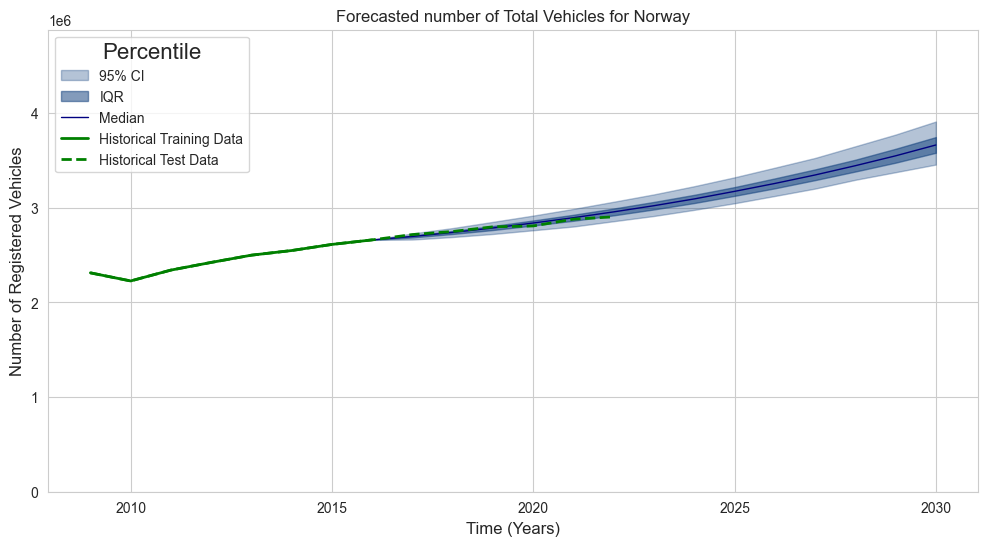

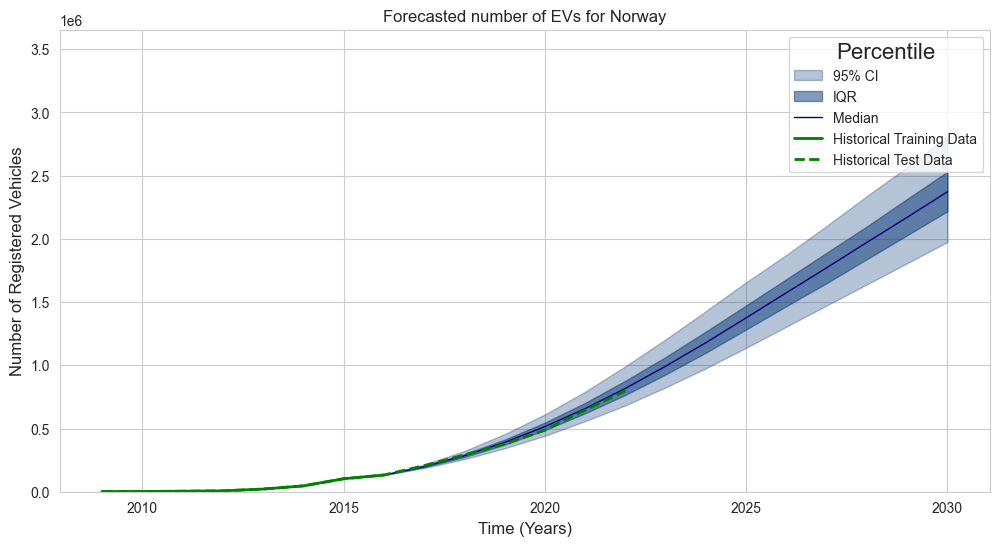

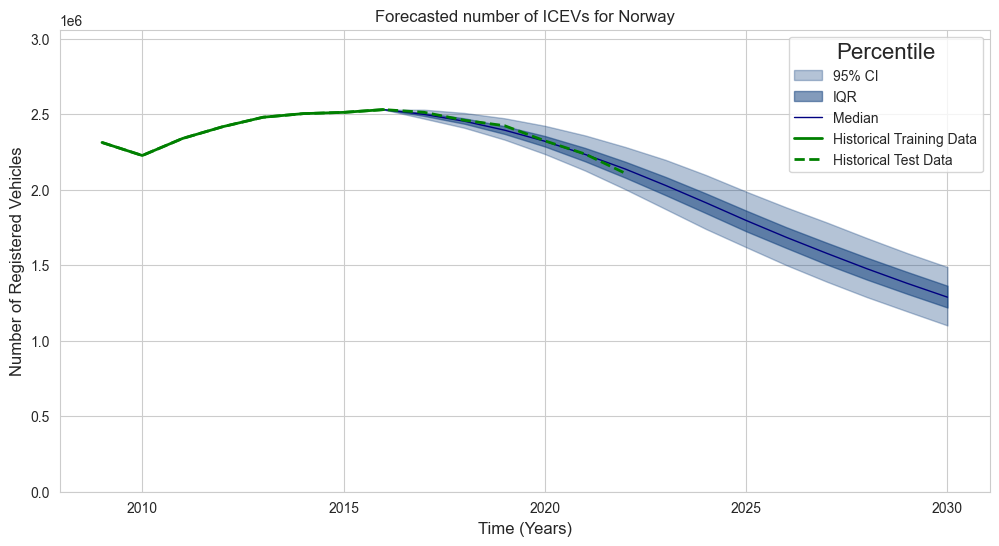

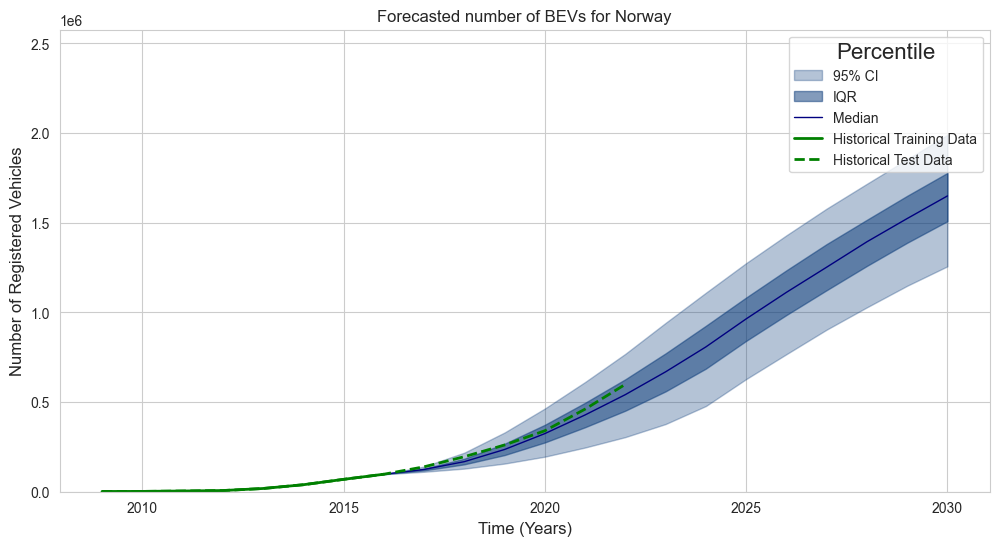

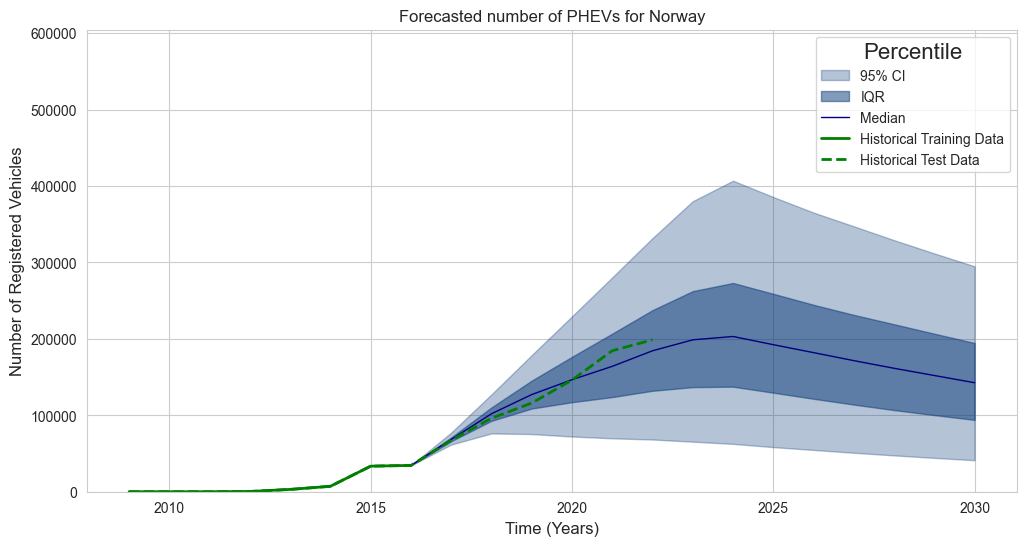

In [1355]:
vehicles_at_horizon = 3100000

growth = vehicles_at_horizon/df['Total_Stock'].loc[t_max]

ev_forecast, icev_forecast, bev_forecast, phev_forecast = forecast_vehicles(growth=growth)

plot_probabilistic_vehicle_forecasts(ev_forecast + icev_forecast, df['Total_Stock'], 'Total Vehicle')
plot_probabilistic_vehicle_forecasts(ev_forecast, df['EV_Stock'], 'EV')
plot_probabilistic_vehicle_forecasts(icev_forecast, df['ICEV_Stock'], 'ICEV')
plot_probabilistic_vehicle_forecasts(bev_forecast, df['BEV_Stock'], 'BEV')
plot_probabilistic_vehicle_forecasts(phev_forecast, df['PHEV_Stock'], 'PHEV')

/Users/isaacflower/miniconda3/envs/probabilistic_ev_demand_modelling/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/isaacflower/miniconda3/envs/probabilistic_ev_demand_modelling/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<Axes: >

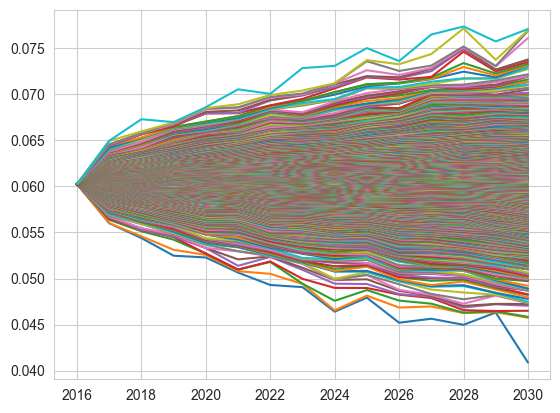

In [1122]:
growth = 1.17

# Project Sales Shares for EVs and BEVs
ev_sales_share = project_sales_share(
    df.loc[:t_max, 'EV_Market_Share_New_Registrations'], 
    icev_ban, 
    1
)

bev_sales_share = project_sales_share(
    df.loc[:t_max, 'BEV_Market_Share_New_EV_Registrations'], 
    phev_ban, 
    1
)

# Train Sales Share GPs on sales share historical data and projected data point
ev_share_gp = train_sales_share_gp(
    ev_sales_share, 
    icev_ban
)

bev_share_gp = train_sales_share_gp(
    bev_sales_share, 
    phev_ban
)

# Truncate and Sample from Sales Share GPs
ev_share_gp_samples = truncate_and_sample_gp(
    ev_share_gp, 
    n_sim, 
    icev_ban
)

bev_share_gp_samples = truncate_and_sample_gp(
    bev_share_gp, 
    n_sim, 
    phev_ban
)

# Derive ICEV and PHEV from EV and BEV sales share samples
icev_share_gp_samples = 1 - ev_share_gp_samples
phev_share_gp_samples = 1 - bev_share_gp_samples

# Forecast the new registration rate
r_reg_forecast_mean, r_reg_forecast_std = train_ARIMA_model(
    endog=(df.loc[:t_max, 'Total_New_Registrations']/df.loc[:t_max, 'Total_Stock']).values, 
    dates=df.loc[:t_max, 'Year_Datetime'].values
)

# Create baseline forecasts for vehicle registration rates (r_reg)
r_reg_baseline_df = simulate_baseline_registration_rates(
    r_reg_forecast_mean, 
    r_reg_forecast_std, 
    n_sim
)

# Select Historical Vehicle Stock Data and add a future projection at time 'horizon'
historical_vehicles = df.loc[:t_max, 'Total_Stock']
historical_vehicles[horizon] = historical_vehicles[t_max] * growth

# Train vehicle stock GP
historical_vehicles_gp = train_stock_gp(
    historical_vehicles, 
    t_max, 
    horizon,
    growth
)

X = np.arange(t_max, horizon+1, 1).reshape(-1,1)

# Sample from vehicle stock GP predictions
stock_prediction_df = pd.DataFrame(
    index=np.arange(t_max, horizon+1), 
    columns=range(0, n_sim), 
    data=historical_vehicles_gp.sample_y(X, n_samples=n_sim)
)

r_reg_df, r_ret_df = shape_registration_and_retirement_rates(
    stock_prediction_df, 
    r_reg_baseline_df,
    n_sim
)

r_reg_df.plot(legend=False)

In [1123]:
r_reg_baseline_df

0         1         2         3         4         5         6    \
2016  0.060251  0.060251  0.060251  0.060251  0.060251  0.060251  0.060251   
2017  0.055998  0.056010  0.056369  0.056474  0.056607  0.056655  0.056709   
2018  0.054387  0.054577  0.055122  0.055270  0.055297  0.055442  0.055455   
2019  0.052474  0.053116  0.054211  0.054483  0.054557  0.054714  0.054780   
2020  0.052281  0.052558  0.052699  0.052713  0.053300  0.053316  0.053319   
2021  0.050642  0.050791  0.050962  0.050977  0.051380  0.052074  0.052942   
2022  0.049299  0.050509  0.051795  0.051849  0.052346  0.052401  0.052403   
2023  0.049064  0.049408  0.049441  0.049965  0.050938  0.051164  0.051589   
2024  0.046404  0.046548  0.047582  0.048981  0.049439  0.049836  0.049849   
2025  0.047919  0.048139  0.048746  0.048971  0.049402  0.049912  0.050370   
2026  0.045202  0.046849  0.047605  0.048246  0.048309  0.048662  0.048773   
2027  0.045635  0.046969  0.047268  0.047882  0.048021  0.048111  0.048216   
2028  0.044975  0.046252  0.046293  0.046565  0.046859  0.047028  0.047268   
2029  0.046307  0.046348  0.046440  0.046470  0.047205  0.047246  0.048143   
2030  0.040888  0.045744  0.045836  0.046500  0.047044  0.047235  0.047334   

           7         8         9    ...       990       991       992  \
2016  0.060251  0.060251  0.060251  ...  0.060251  0.060251  0.060251   
2017  0.056807  0.056928  0.056968  ...  0.064196  0.064409  0.064414   
2018  0.055905  0.055955  0.056079  ...  0.065245  0.065304  0.065645   
2019  0.054843  0.054910  0.055000  ...  0.066379  0.066401  0.066452   
2020  0.053658  0.053767  0.053781  ...  0.066930  0.067011  0.067036   
2021  0.052975  0.053362  0.053420  ...  0.067441  0.067599  0.067619   
2022  0.052467  0.052490  0.052502  ...  0.068529  0.068640  0.068752   
2023  0.051639  0.051672  0.051727  ...  0.069243  0.069293  0.069296   
2024  0.049925  0.049962  0.050765  ...  0.069950  0.070220  0.070221   
2025  0.050393  0.050675  0.050730  ...  0.070869  0.071053  0.071089   
2026  0.049378  0.049686  0.049700  ...  0.071161  0.071225  0.071239   
2027  0.048329  0.048800  0.049102  ...  0.071631  0.071657  0.071804   
2028  0.047743  0.048481  0.049178  ...  0.072447  0.072951  0.073375   
2029  0.048221  0.048247  0.048425  ...  0.071834  0.072030  0.072248   
2030  0.047376  0.047415  0.047488  ...  0.073099  0.073154  0.073282   

           993       994       995       996       997       998       999  
2016  0.060251  0.060251  0.060251  0.060251  0.060251  0.060251  0.060251  
2017  0.064432  0.064450  0.064500  0.064525  0.064558  0.064926  0.064944  
2018  0.065647  0.065689  0.065697  0.065735  0.065777  0.065960  0.067284  
2019  0.066542  0.066695  0.066709  0.066757  0.066888  0.066928  0.066965  
2020  0.067906  0.067932  0.068080  0.068355  0.068449  0.068491  0.068588  
2021  0.067934  0.067974  0.068236  0.068527  0.068576  0.068903  0.070529  
2022  0.068789  0.069320  0.069378  0.069620  0.069702  0.069904  0.070040  
2023  0.069491  0.069856  0.069913  0.069955  0.070071  0.070396  0.072832  
2024  0.070631  0.070779  0.071061  0.071149  0.071158  0.071184  0.073072  
2025  0.071815  0.071870  0.071963  0.072600  0.073578  0.073696  0.074999  
2026  0.071587  0.071723  0.071833  0.072082  0.072517  0.073248  0.073594  
2027  0.071879  0.072494  0.072743  0.072850  0.073104  0.074354  0.076471  
2028  0.074614  0.074890  0.074935  0.075041  0.075176  0.077131  0.077346  
2029  0.072478  0.072640  0.072658  0.073014  0.073065  0.073731  0.075726  
2030  0.073498  0.073745  0.073747  0.076088  0.076851  0.076937  0.077070  

[15 rows x 1000 columns]

In [1118]:
difference_df = stock_prediction_df.diff(1)
difference_df

0             1             2             3             4    \
2016           NaN           NaN           NaN           NaN           NaN   
2017  48700.450051  37500.711338  35799.071182  59874.372818  47757.755055   
2018  19306.458027  26792.547587  42759.455354  52744.540253  58598.458620   
2019  29825.496858  64908.079449  65452.608584  58630.265586  56858.486747   
2020  39356.645017  37105.065197  40369.491553  52943.739920  57256.303070   
2021  24330.790979  50997.187973  57659.716040  44341.201476  45580.339350   
2022  43304.261832  52087.207029  30141.279323  43143.407767  54416.385614   
2023  27114.699893  30078.254269  40901.761586  36677.195248  47123.120581   
2024  34495.495045  38020.434551  42519.427475  23590.091822  23203.415036   
2025  35042.570251  40382.256107  26003.016558  23306.522647  24199.474900   
2026  36760.309557  29593.085607  19521.339214  25365.090460  17629.106935   
2027  27503.158911  24128.971452  23530.029942  19433.683308  16894.032775   
2028  28558.997833  19302.692235  13087.558607   6830.677541  12294.380936   
2029  28124.498295  -5266.073443  16696.609953  11808.008226  -1485.004440   
2030  30047.026412   6841.638863  -1962.052353  -6217.802458  -7859.400948   

               5             6             7             8             9    \
2016           NaN           NaN           NaN           NaN           NaN   
2017  60086.284807  45377.549000  38404.434447  55288.782663  37812.778707   
2018  44316.552689  44129.657829  40312.968317  46497.274663  37879.360320   
2019  68345.912807  57194.287547  18558.535057  52326.093539  50588.121382   
2020  55274.366582  44848.242073  40661.650691  39769.690444  41775.296180   
2021  42468.709629  55429.259440  29335.915299  38829.059134  44310.538993   
2022  52359.599066  35513.291766  29804.749628  37920.566981  40003.965826   
2023  40773.529848  62779.397808  28516.669288  28875.076752  39349.571243   
2024  25755.608196  39233.810195  37537.723000  41149.359344  19552.641035   
2025  18856.209410  29209.218860  30793.863922  24509.788792  47389.282155   
2026  35960.483976  30741.845510  32894.562886  19668.196883  31645.639667   
2027    510.530355   5133.076248  14730.956263  18396.635007  13917.076915   
2028   9709.100327  17797.597542  31231.711729  26513.463506  29306.637353   
2029   -390.013434  -6885.154181  40104.979213    554.958932   1973.309945   
2030  -1561.492890  -8023.751075  39582.192272  22174.900568  16964.999039   

      ...           990           991           992           993  \
2016  ...           NaN           NaN           NaN           NaN   
2017  ...  50378.668068  67508.136107  52921.825769  31215.076913   
2018  ...  52211.706544  54123.115951  49138.134060  48379.529714   
2019  ...  37964.824167  57697.978218  52813.646308  34857.492990   
2020  ...  64770.634238  55032.974291  47410.854246  46587.819580   
2021  ...  30042.310588  50657.765516  60075.243936  43387.889690   
2022  ...  52613.310560  49409.108241  34374.213100  48112.516998   
2023  ...  37901.073093  36291.431325  43001.057538  37326.292873   
2024  ...  27424.793747  40149.952617  36579.489651  34608.469014   
2025  ...  32072.632615  16369.052205  32337.790043  33288.121327   
2026  ...  36595.832715  14136.877110  27557.771571  33081.845289   
2027  ...  18064.901555   6981.226751  10051.365914  20948.354210   
2028  ...  14691.736809  -3325.796174   9492.520648  27392.931874   
2029  ...   3157.440575   7351.354627    795.625288   1825.126550   
2030  ...  -5423.325165     82.849634  -4080.756422  11461.703190   

               994           995           996           997           998  \
2016           NaN           NaN           NaN           NaN           NaN   
2017  45226.373966  51663.020790  47095.643297  32903.336375  49721.830495   
2018  46901.026530  53559.621934  50112.152070  25918.068894  51741.167219   
2019  49305.666979  31284.921654  71768.066808  54105.800144  43347.526146   
2020  46483.574393  51

In [1119]:
stock_prediction_df.diff(1).div(stock_prediction_df)

0         1         2         3         4         5         6    \
2016       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2017  0.017969  0.013894  0.013272  0.022001  0.017627  0.022077  0.016763   
2018  0.007073  0.009829  0.015605  0.019012  0.021170  0.016022  0.016041   
2019  0.010809  0.023258  0.023329  0.020697  0.020128  0.024113  0.020366   
2020  0.014062  0.013121  0.014185  0.018346  0.019866  0.019129  0.015719   
2021  0.008618  0.017714  0.019858  0.015133  0.015569  0.014484  0.019057   
2022  0.015107  0.017771  0.010274  0.014510  0.018248  0.017544  0.012063   
2023  0.009371  0.010158  0.013750  0.012185  0.015556  0.013478  0.020879   
2024  0.011781  0.012677  0.014092  0.007776  0.007602  0.008442  0.012880   
2025  0.011826  0.013286  0.008545  0.007624  0.007866  0.006142  0.009498   
2026  0.012254  0.009642  0.006374  0.008229  0.005697  0.011578  0.009897   
2027  0.009085  0.007801  0.007624  0.006266  0.005430  0.000164  0.001650   
2028  0.009346  0.006202  0.004223  0.002197  0.003936  0.003116  0.005688   
2029  0.009119 -0.001695  0.005358  0.003784 -0.000476 -0.000125 -0.002205   
2030  0.009649  0.002197 -0.000630 -0.001997 -0.002524 -0.000501 -0.002577   

           7         8         9    ...       990       991       992  \
2016       NaN       NaN       NaN  ...       NaN       NaN       NaN   
2017  0.014224  0.020350  0.014008  ...  0.018576  0.024736  0.019496   
2018  0.014711  0.016826  0.013838  ...  0.018889  0.019446  0.017780   
2019  0.006727  0.018584  0.018146  ...  0.013548  0.020310  0.018752   
2020  0.014524  0.013927  0.014763  ...  0.022592  0.019003  0.016555   
2021  0.010370  0.013416  0.015418  ...  0.010370  0.017192  0.020546   
2022  0.010426  0.012932  0.013728  ...  0.017838  0.016492  0.011619   
2023  0.009877  0.009751  0.013324  ...  0.012687  0.011968  0.014327   
2024  0.012835  0.013706  0.006577  ...  0.009096  0.013068  0.012041   
2025  0.010419  0.008098  0.015690  ...  0.010526  0.005299  0.010533   
2026  0.011007  0.006456  0.010369  ...  0.011868  0.004556  0.008896   
2027  0.004905  0.006002  0.004539  ...  0.005824  0.002245  0.003234   
2028  0.010293  0.008577  0.009469  ...  0.004714 -0.001071  0.003045   
2029  0.013044  0.000179  0.000637  ...  0.001012  0.002361  0.000255   
2030  0.012711  0.007121  0.005448  ... -0.001742  0.000027 -0.001310   

           993       994       995       996       997       998       999  
2016       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
2017  0.011592  0.016708  0.019041  0.017387  0.012211  0.018339  0.017301  
2018  0.017649  0.017032  0.019358  0.018164  0.009527  0.018726  0.014752  
2019  0.012557  0.017590  0.011181  0.025355  0.019501  0.015446  0.014417  
2020  0.016505  0.016313  0.018218  0.018402  0.011908  0.012413  0.016741  
2021  0.015139  0.013000  0.014618  0.017360  0.007481  0.017071  0.010290  
2022  0.016510  0.016214  0.015372  0.019474  0.016281  0.011268  0.016483  
2023  0.012647  0.010232  0.013813  0.016541  0.009179  0.009325  0.008341  
2024  0.011590  0.009367  0.010885  0.014587  0.009401  0.008281  0.010368  
2025  0.011025  0.009373  0.010003  0.010332  0.016432  0.006472  0.010917  
2026  0.010838  0.008156  0.006527  0.003808  0.009501  0.009373  0.011545  
2027  0.006816  0.004372  0.008959  0.004709  0.008061  0.003811  0.002694  
2028  0.008834  0.006151  0.006774 -0.002948  0.009385  0.012401  0.005455  
2029  0.000588  0.008842  0.001527 -0.000060  0.007123  0.003115  0.010119  
2030  0.003681  0.002613 -0.000393 -0.007621  0.010044  0.009924  0.006574  

[15 rows x 1000 columns]

In [983]:
r_reg_df.sub(r_ret_df)

0         1         2         3         4         5         6    \
2016       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2017  0.011705  0.008723  0.016121  0.023160  0.021207  0.019834  0.016052   
2018  0.014863  0.022079  0.016731  0.022482  0.017869  0.024057  0.014750   
2019  0.009527  0.013554  0.018636  0.015088  0.018869  0.015435  0.022084   
2020  0.014159  0.017746  0.011982  0.017741  0.022002  0.021764  0.016966   
2021  0.009427  0.015352  0.020837  0.015253  0.014190  0.014423  0.018196   
2022  0.013820  0.010500  0.011299  0.014662  0.016715  0.017200  0.017376   
2023  0.012548  0.020141  0.015565  0.011188  0.012402  0.010952  0.011194   
2024  0.008409  0.014484  0.014087  0.011688  0.013525  0.013841  0.018844   
2025  0.011895  0.010247  0.008188  0.009642  0.010237  0.009778  0.007452   
2026  0.008131  0.007105  0.007672  0.006307  0.006565  0.000295  0.006053   
2027  0.011691  0.007968  0.005757  0.003283  0.000896  0.006339  0.008000   
2028  0.012164  0.004828  0.006145  0.003310  0.001222  0.002136  0.004193   
2029  0.014158  0.003672 -0.002696  0.000180 -0.000674 -0.000351 -0.000837   
2030  0.003533 -0.000741  0.005444  0.001841  0.000724 -0.000039 -0.004594   

           7         8         9    ...       990       991       992  \
2016       NaN       NaN       NaN  ...       NaN       NaN       NaN   
2017  0.013016  0.018226  0.010819  ...  0.017641  0.023695  0.017632   
2018  0.010441  0.016878  0.020541  ...  0.020967  0.019235  0.020317   
2019  0.014200  0.021391  0.013637  ...  0.014534  0.020564  0.019143   
2020  0.011806  0.014856  0.018302  ...  0.019109  0.019367  0.014986   
2021  0.011658  0.013225  0.010225  ...  0.009622  0.020236  0.019238   
2022  0.015036  0.009993  0.014703  ...  0.020319  0.014986  0.015135   
2023  0.008605  0.014175  0.013183  ...  0.010849  0.013348  0.012993   
2024  0.005944  0.009100  0.015922  ...  0.010552  0.007320  0.013759   
2025  0.008989  0.009100  0.005702  ...  0.013760  0.008554  0.006771   
2026  0.009167  0.005328  0.010109  ...  0.007977  0.002678  0.007766   
2027  0.014722  0.008458  0.009827  ...  0.006405  0.003129  0.007545   
2028  0.009429  0.006787  0.003842  ...  0.002738  0.003116  0.001565   
2029  0.013267  0.005367  0.006238  ...  0.003401  0.000350  0.001611   
2030  0.009702  0.003089  0.003008  ... -0.002152 -0.001053 -0.002632   

           993       994       995       996       997       998       999  
2016       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
2017  0.011507  0.019437  0.020498  0.018468  0.008371  0.019018  0.015357  
2018  0.015165  0.016398  0.013331  0.018475  0.018784  0.016024  0.018596  
2019  0.016800  0.012903  0.019111  0.019410  0.009041  0.018509  0.010151  
2020  0.017021  0.018706  0.016165  0.022571  0.019003  0.014495  0.018569  
2021  0.012537  0.013378  0.013101  0.021155  0.007316  0.012727  0.011846  
2022  0.015291  0.014380  0.015685  0.016050  0.011195  0.009808  0.015986  
2023  0.013339  0.012631  0.012518  0.017746  0.015621  0.010015  0.011452  
2024  0.012478  0.009297  0.010613  0.012090  0.010512  0.011843  0.006647  
2025  0.012413  0.009307  0.011523  0.009872  0.008518  0.007157  0.009806  
2026  0.009440  0.006424  0.010836  0.006217  0.009440  0.005458  0.005897  
2027  0.008919  0.007940  0.004249  0.001500  0.011536  0.010235  0.012018  
2028  0.002267  0.004791  0.003639  0.005158  0.012558  0.001179  0.006389  
2029  0.007622  0.003467  0.006921 -0.008496  0.005778  0.011316  0.007003  
2030  0.001071  0.006953 -0.002236 -0.004791  0.008532  0.008063  0.006325  

[15 rows x 1000 columns]

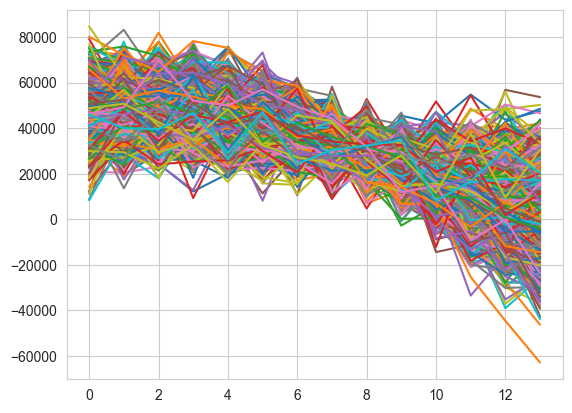

In [1120]:
plt.plot(np.subtract(new_vehicles_array, retired_vehicles_array))

<Axes: >

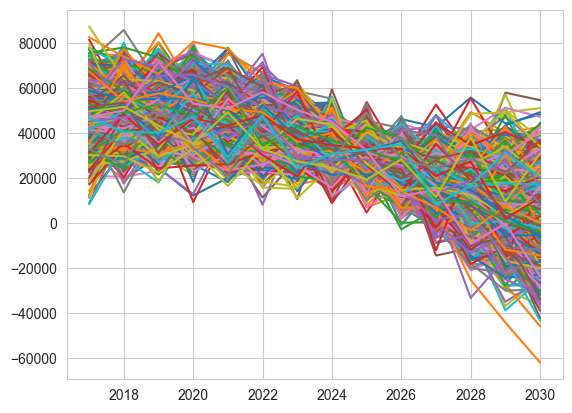

In [1121]:
difference_df.plot(legend=False)

In [1021]:
new_evs_array[0]

0      49103.104002
1      54646.783342
2      58906.012041
3      53392.685692
4      68652.956612
           ...     
995    91718.540594
996    81014.161129
997    75709.334579
998    84203.829877
999    84433.766351
Length: 1000, dtype: float64

In [1022]:
len(new_evs_array)

14

In [1023]:
new_evs_mean = []
for i in range(len(new_evs_array)):
    new_evs_mean.append(np.mean(new_evs_array[i]))

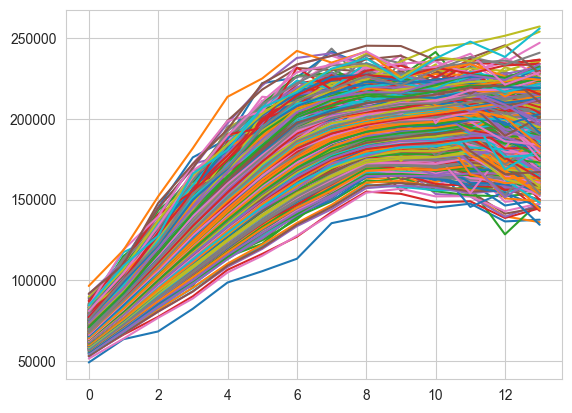

In [1024]:
plt.plot(new_evs_array)

In [1032]:
np.arange(t_max, 2023)

array([2016, 2017, 2018, 2019, 2020, 2021, 2022])

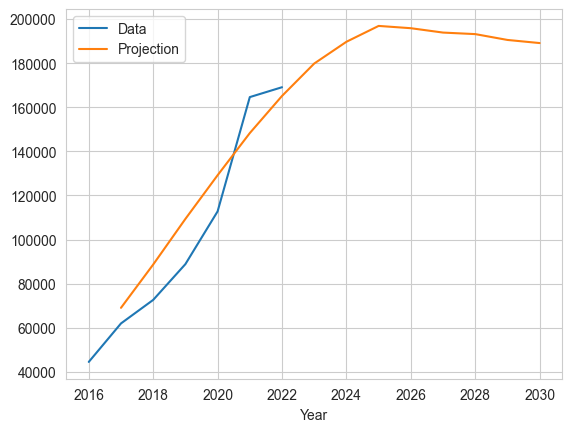

In [1036]:
fig, ax = plt.subplots()

df.loc[t_max:, 'EV_New_Registrations'].plot(ax=ax, label='Data')
ax.plot(np.arange(t_max+1, 2031), new_evs_mean, label='Projection')

plt.legend()
plt.show()

<Axes: xlabel='Year'>

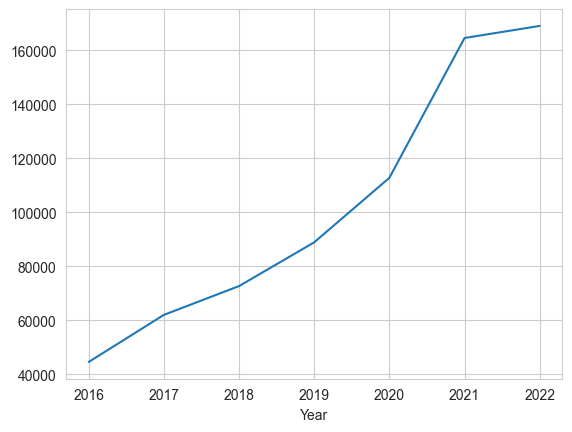

In [1000]:
df.loc[t_max:, 'EV_New_Registrations'].plot()

In [1344]:
# Creates a range of numeric dates between t0 and t1 at a given sample rate
forecast_dates = np.arange(t_max, horizon+1)

# Create dataframes that contain a column for each simulation and a row for each forecasted date
ev_forecast= pd.DataFrame(index=forecast_dates, columns=range(0, n_sim), dtype=float)
icev_forecast = pd.DataFrame(index=forecast_dates, columns=range(0, n_sim), dtype=float)
bev_forecast= pd.DataFrame(index=forecast_dates, columns=range(0, n_sim), dtype=float)
phev_forecast = pd.DataFrame(index=forecast_dates, columns=range(0, n_sim), dtype=float)

# Populate forecast with inital starting registrations
ev_forecast.iloc[0] = df.loc[t_max, 'EV_Stock']
icev_forecast.iloc[0] = df.loc[t_max, 'ICEV_Stock']
bev_forecast.iloc[0] = df.loc[t_max, 'BEV_Stock']
phev_forecast.iloc[0] = df.loc[t_max, 'PHEV_Stock']

new_vehicles_array = []
retired_vehicles_array = []

new_evs_array = []

# Making the forecasts by adding new registrations and removing retired vehicles
for t in range(t_max+1, horizon+1):
    new_vehicles = r_reg_df.loc[t] * (ev_forecast.loc[t-1] + icev_forecast.loc[t-1])
    retired_vehicles = r_ret_df.loc[t] * (ev_forecast.loc[t-1] + icev_forecast.loc[t-1])

    new_vehicles_array.append(new_vehicles)
    retired_vehicles_array.append(retired_vehicles)

    new_evs = ev_share_gp_samples.loc[t] * new_vehicles * 1 # FUDGE FACTOR!!
    new_icevs = icev_share_gp_samples.loc[t] * new_vehicles * 1
    new_bevs = bev_share_gp_samples.loc[t] * new_evs
    new_phevs = phev_share_gp_samples.loc[t] * new_evs

    new_evs_array.append(new_evs)

    retired_evs = r_ret_df.loc[t] * ev_forecast.loc[t-1] * 1
    retired_icevs = r_ret_df.loc[t] * icev_forecast.loc[t-1] * 1 # FUDGE FACTOR!!
    retired_bevs = r_ret_df.loc[t] * bev_forecast.loc[t-1]
    retired_phevs = r_ret_df.loc[t] * phev_forecast.loc[t-1]

    ev_forecast.loc[t] = ev_forecast.loc[t-1] + new_evs - retired_evs
    icev_forecast.loc[t] = icev_forecast.loc[t-1] + new_icevs - retired_icevs
    bev_forecast.loc[t] = bev_forecast.loc[t-1] + new_bevs - retired_bevs
    phev_forecast.loc[t] = phev_forecast.loc[t-1] + new_phevs - retired_phevs 

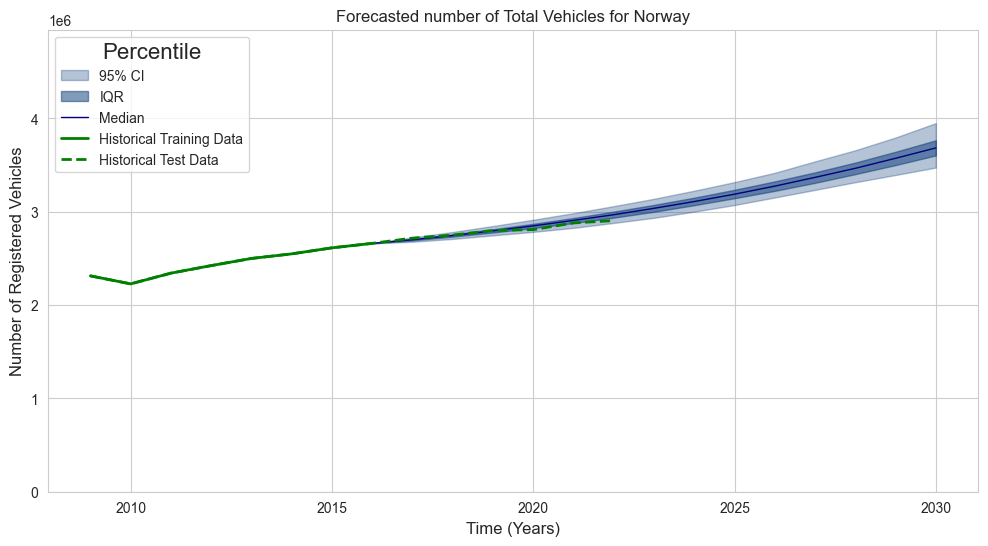

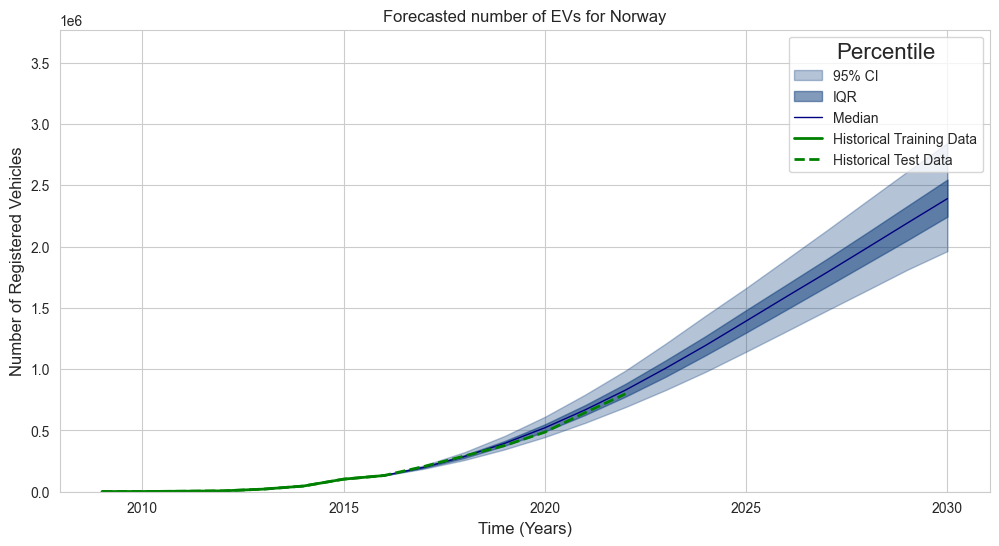

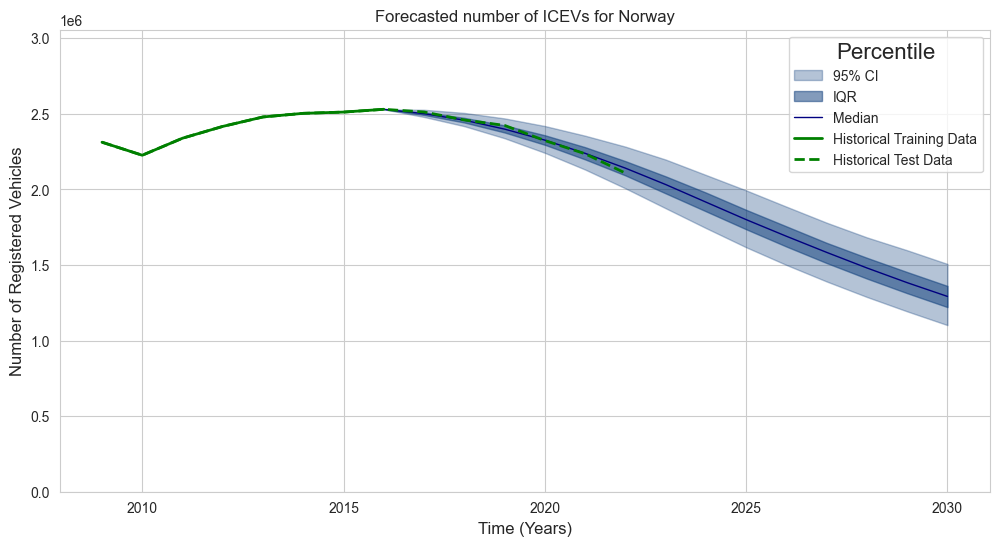

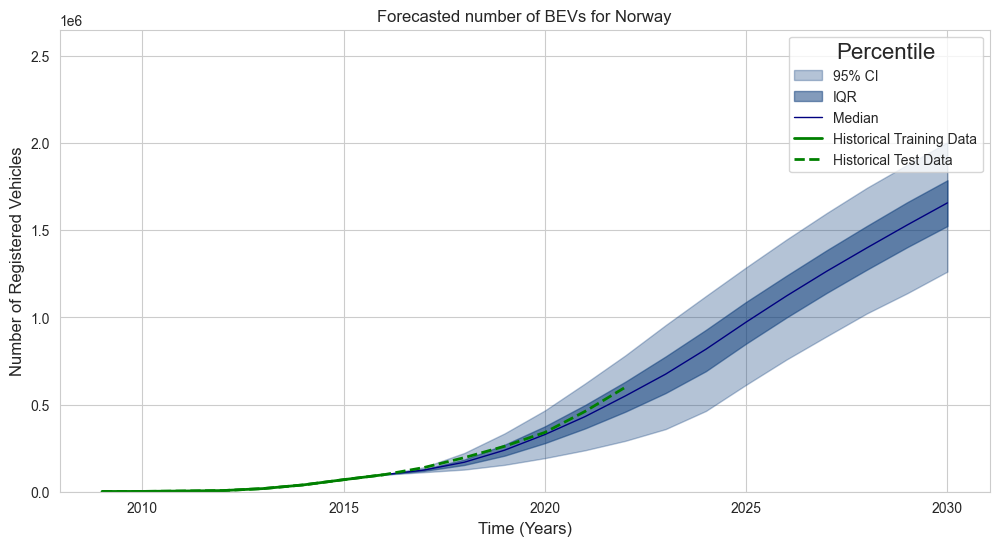

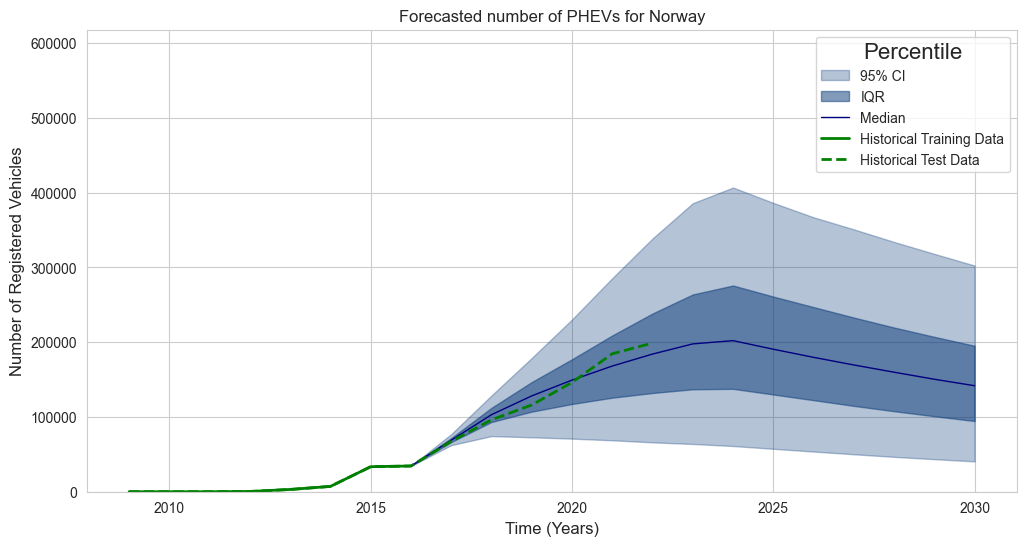

In [1345]:
plot_probabilistic_vehicle_forecasts(ev_forecast + icev_forecast, df['Total_Stock'], 'Total Vehicle')
plot_probabilistic_vehicle_forecasts(ev_forecast, df['EV_Stock'], 'EV')
plot_probabilistic_vehicle_forecasts(icev_forecast, df['ICEV_Stock'], 'ICEV')
plot_probabilistic_vehicle_forecasts(bev_forecast, df['BEV_Stock'], 'BEV')
plot_probabilistic_vehicle_forecasts(phev_forecast, df['PHEV_Stock'], 'PHEV')

In [1217]:
growth = 1.17

# Project Sales Shares for EVs and BEVs
ev_sales_share = project_sales_share(
    df.loc[:t_max, 'EV_Market_Share_New_Registrations'], 
    icev_ban, 
    1
)

bev_sales_share = project_sales_share(
    df.loc[:t_max, 'BEV_Market_Share_New_EV_Registrations'], 
    phev_ban, 
    1
)

# Train Sales Share GPs on sales share historical data and projected data point
ev_share_gp = train_sales_share_gp(
    ev_sales_share, 
    icev_ban
)

bev_share_gp = train_sales_share_gp(
    bev_sales_share, 
    phev_ban
)

# Truncate and Sample from Sales Share GPs
ev_share_gp_samples = truncate_and_sample_gp(
    ev_share_gp, 
    n_sim, 
    icev_ban
)

bev_share_gp_samples = truncate_and_sample_gp(
    bev_share_gp, 
    n_sim, 
    phev_ban
)

# Derive ICEV and PHEV from EV and BEV sales share samples
icev_share_gp_samples = 1 - ev_share_gp_samples
phev_share_gp_samples = 1 - bev_share_gp_samples

# Forecast the new registration rate
r_reg_forecast_mean, r_reg_forecast_std = train_ARIMA_model(
    endog=(df.loc[:t_max, 'Total_New_Registrations']/df.loc[:t_max, 'Total_Stock']).values, 
    dates=df.loc[:t_max, 'Year_Datetime'].values
)

# Create baseline forecasts for vehicle registration rates (r_reg)
r_reg_baseline_df = simulate_baseline_registration_rates(
    r_reg_forecast_mean, 
    r_reg_forecast_std, 
    n_sim
)

# Select Historical Vehicle Stock Data and add a future projection at time 'horizon'
historical_vehicles = df.loc[:t_max, 'Total_Stock']
historical_vehicles[horizon] = historical_vehicles[t_max] * growth

# Train vehicle stock GP
historical_vehicles_gp = train_stock_gp(
    historical_vehicles, 
    t_max, 
    horizon,
    growth
)

X = np.arange(t_max, horizon+1, 1).reshape(-1,1)

# Sample from vehicle stock GP predictions
stock_prediction_df = pd.DataFrame(
    index=np.arange(t_max, horizon+1), 
    columns=range(0, n_sim), 
    data=historical_vehicles_gp.sample_y(X, n_samples=n_sim)
)

r_reg_df, r_ret_df = shape_registration_and_retirement_rates(
    stock_prediction_df, 
    r_reg_baseline_df,
    n_sim
)

# Creates a range of numeric dates between t0 and t1 at a given sample rate
forecast_dates = np.arange(t_max, horizon+1)

# Create dataframes that contain a column for each simulation and a row for each forecasted date
ev_forecast= pd.DataFrame(index=forecast_dates, columns=range(0, n_sim), dtype=float)
icev_forecast = pd.DataFrame(index=forecast_dates, columns=range(0, n_sim), dtype=float)
bev_forecast= pd.DataFrame(index=forecast_dates, columns=range(0, n_sim), dtype=float)
phev_forecast = pd.DataFrame(index=forecast_dates, columns=range(0, n_sim), dtype=float)

# Populate forecast with inital starting registrations
ev_forecast.iloc[0] = df.loc[t_max, 'EV_Stock']
icev_forecast.iloc[0] = df.loc[t_max, 'ICEV_Stock']
bev_forecast.iloc[0] = df.loc[t_max, 'BEV_Stock']
phev_forecast.iloc[0] = df.loc[t_max, 'PHEV_Stock']

new_vehicles_array = []
retired_vehicles_array = []

# Making the forecasts by adding new registrations and removing retired vehicles
for t in range(t_max+1, horizon+1):
    new_vehicles = r_reg_df.loc[t] * (ev_forecast.loc[t-1] + icev_forecast.loc[t-1])
    retired_vehicles = r_ret_df.loc[t] * (ev_forecast.loc[t-1] + icev_forecast.loc[t-1])

    new_vehicles_array.append(new_vehicles)
    retired_vehicles_array.append(retired_vehicles)

    new_evs = ev_share_gp_samples.loc[t] * new_vehicles * 1 # FUDGE FACTOR!!
    new_icevs = icev_share_gp_samples.loc[t] * new_vehicles * 1
    new_bevs = bev_share_gp_samples.loc[t] * new_evs
    new_phevs = phev_share_gp_samples.loc[t] * new_evs

    retired_evs = r_ret_df.loc[t] * ev_forecast.loc[t-1] * 1
    retired_icevs = r_ret_df.loc[t] * icev_forecast.loc[t-1] * 1 # FUDGE FACTOR!!
    retired_bevs = r_ret_df.loc[t] * bev_forecast.loc[t-1]
    retired_phevs = r_ret_df.loc[t] * phev_forecast.loc[t-1]

    ev_forecast.loc[t] = ev_forecast.loc[t-1] + new_evs - retired_evs
    icev_forecast.loc[t] = icev_forecast.loc[t-1] + new_icevs - retired_icevs
    bev_forecast.loc[t] = bev_forecast.loc[t-1] + new_bevs - retired_bevs
    phev_forecast.loc[t] = phev_forecast.loc[t-1] + new_phevs - retired_phevs 

/Users/isaacflower/miniconda3/envs/probabilistic_ev_demand_modelling/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/isaacflower/miniconda3/envs/probabilistic_ev_demand_modelling/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [1218]:
len(retired_vehicles_array)

14

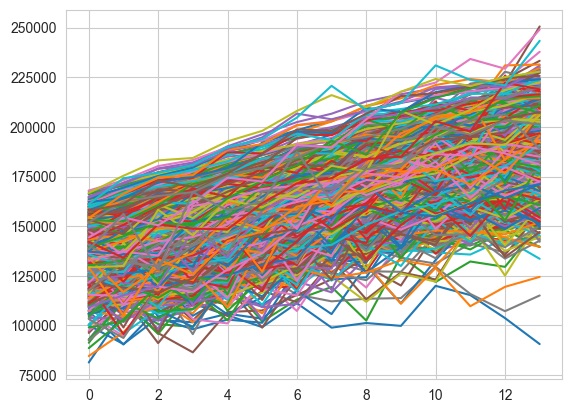

In [1219]:
# plt.plot(new_vehicles_array)
plt.plot(retired_vehicles_array)

In [ ]:
np.arange()

<Axes: >

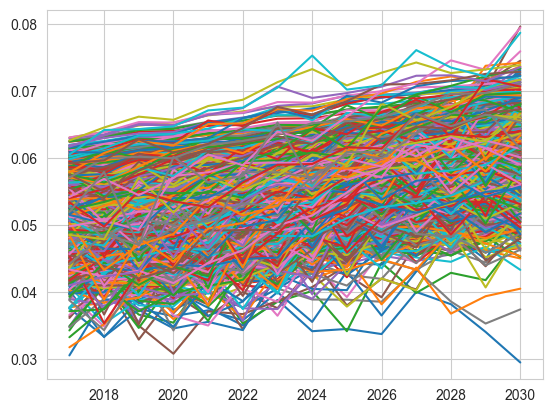

In [1346]:
r_ret_df.plot(legend=False)

<Axes: >

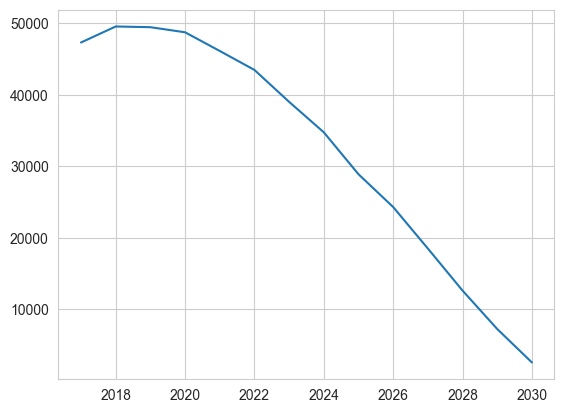

In [1221]:
difference_df.mean(axis=1).plot()

<Axes: >

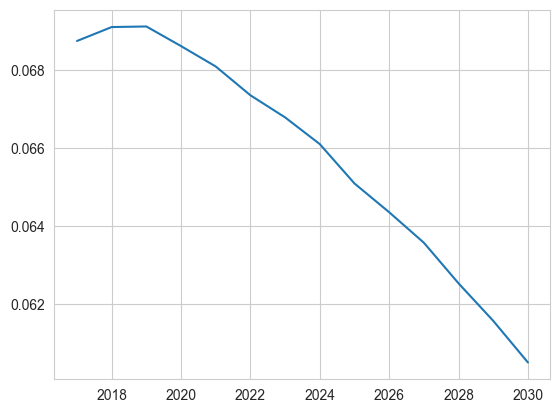

In [1222]:
r_reg_df.median(axis=1).plot()

<Axes: >

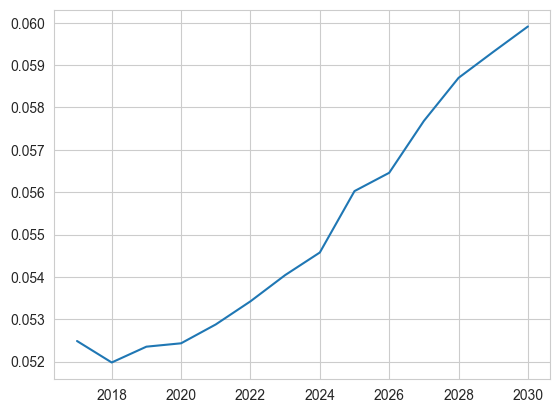

In [1223]:
r_ret_df.median(axis=1).plot()

In [1224]:
new_vehicles_mean = []
for i in range(len(new_vehicles_array)):
    new_vehicles_mean.append(np.mean(new_vehicles_array[i]))
    

In [1225]:
retired_vehicles_mean = []
for i in range(len(retired_vehicles_array)):
    retired_vehicles_mean.append(np.mean(retired_vehicles_array[i]))

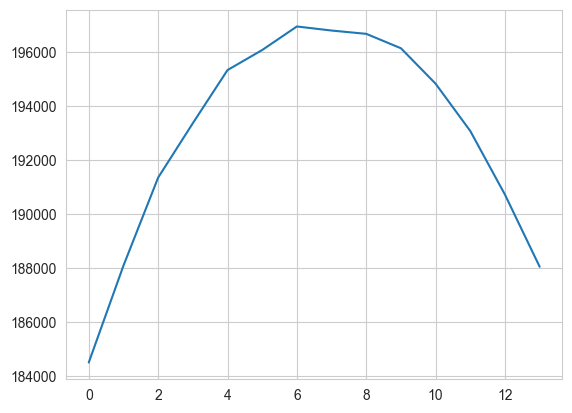

In [1226]:
plt.plot(new_vehicles_mean)
plt.show()

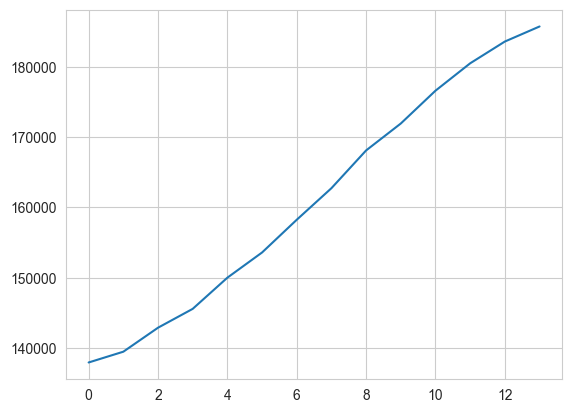

In [1227]:
plt.plot(retired_vehicles_mean)
plt.show()

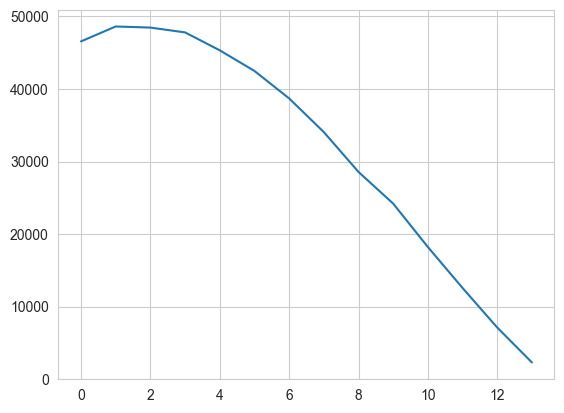

In [1228]:
plt.plot(np.subtract(new_vehicles_mean, retired_vehicles_mean))
plt.show()

<Axes: xlabel='Year'>

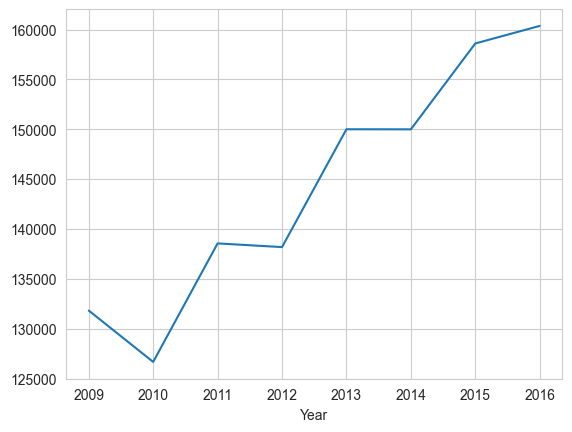

In [1229]:
df.loc[:t_max, 'Total_New_Registrations'].plot()

# Experimenting with "Difference"

I need to learn the historical difference!

In [1230]:
df

Year  BEV_Stock  PHEV_Stock  EV_Stock  ICEV_Stock  Total_Stock  \
Year                                                                   
2009  2009       1388           0      1388   2311945.0    2313333.0   
2010  2010       1782           0      1782   2225718.0    2227500.0   
2011  2011       3982           1      3983   2338370.0    2342353.0   
2012  2012       6543         341      6884   2416449.0    2423333.0   
2013  2013      18000        3034     21034   2478966.0    2500000.0   
2014  2014      39000        7106     46106   2502914.0    2549020.0   
2015  2015      69000       33455    102455   2511181.0    2613636.0   
2016  2016      97532       34431    131963   2529636.0    2661599.0   
2017  2017     138983       67315    206298   2511668.0    2717966.0   
2018  2018     195351       96133    291484   2458957.0    2750441.0   
2019  2019     260692      116042    376734   2422919.0    2799653.0   
2020  2020     340002      146153    486155   2322785.0    2808940.0   
2021  2021     460734      184503    645237   2235405.0    2880642.0   
2022  2022     599169      198841    798010   2107570.0    2905580.0   

      BEV_Stock_Share_Total  PHEV_Stock_Share_Total  EV_Stock_Share_Total  \
Year                                                                        
2009                 0.0006                  0.0000                0.0006   
2010                 0.0008                  0.0000                0.0008   
2011                 0.0017                  0.0000                0.0017   
2012                 0.0027                  0.0001                0.0028   
2013                 0.0072                  0.0012                0.0084   
2014                 0.0153                  0.0028                0.0181   
2015                 0.0264                  0.0128                0.0392   
2016                 0.0366                  0.0130                0.0496   
2017                 0.0511                  0.0248                0.0759   
2018                 0.0710                  0.0349                0.1059   
2019                 0.0931                  0.0414                0.1345   
2020                 0.1171                  0.0411                0.1582   
2021                 0.1550                  0.0591                0.2141   
2022                 0.1676                  0.0614                0.2290   

      ICEV_Stock_Share_Total  ...  EV_New_Registrations  \
Year                          ...                         
2009                  0.9994  ...                   145   
2010                  0.9992  ...                   380   
2011                  0.9983  ...                  2010   
2012                  0.9972  ...                  4596   
2013                  0.9916  ...                  8364   
2014                  0.9819  ...                 19697   
2015                  0.9608  ...                 33408   
2016                  0.9504  ...                 44530   
2017                  0.9241  ...                 61980   
2018                  0.8941  ...                 72650   
2019                  0.8655  ...                 88873   
2020                  0.8418  ...                112789   
2021                  0.7859  ...                164618   
2022                  0.7710  ...                169094   

      ICEV_New_Registrations  Total_New_Registrations  \
Year                                                    
2009                131673.0                 131818.0   
2010                126287.0                 126667.0   
2011                136542.0                 138552.0   
2012                133586.0                 138182.0   
2013                141636.0                 150000.0   
2014                130295.0                 149992.0   
2015                125195.0                 158603.0   
2016                115833.0                 160363.0   
2017                105722.0                 167702.0   
2018                 86189.0                 158

<Axes: xlabel='Year'>

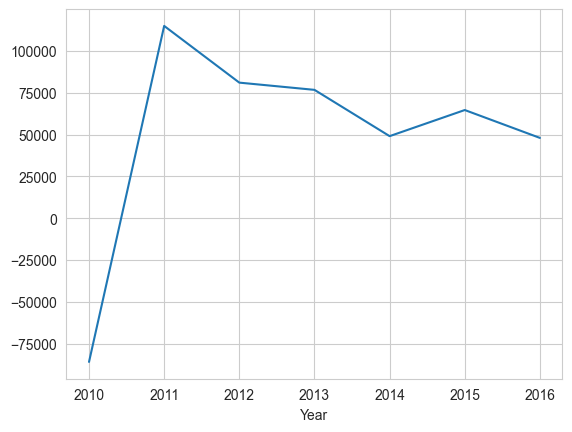

In [1231]:
df.loc[:t_max, 'Total_Stock'].diff().plot()

<Axes: xlabel='Year'>

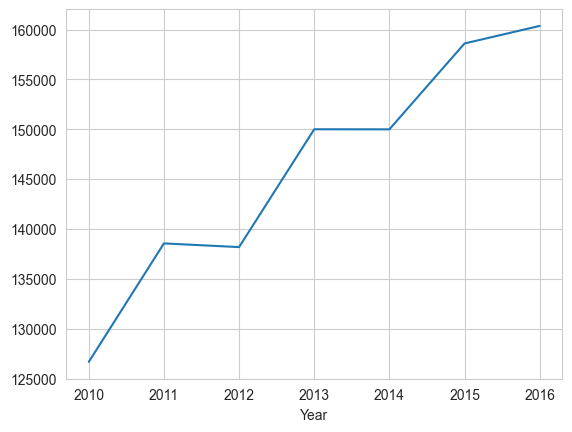

In [1232]:
df.loc[2010:t_max, 'Total_New_Registrations'].plot()

<Axes: xlabel='Year'>

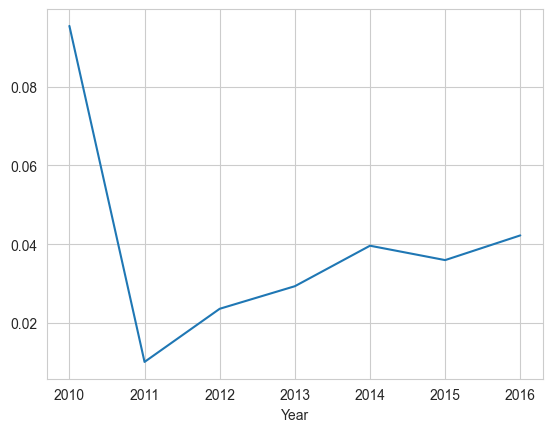

In [1233]:
(df.loc[:t_max, 'Total_New_Registrations'] - df.loc[:t_max, 'Total_Stock'].diff()).div(df.loc[:t_max, 'Total_Stock']).plot()

In [1234]:
(df.loc[:t_max, 'Total_New_Registrations'] - df.loc[:t_max, 'Total_Stock'].diff()).div(df.loc[:t_max, 'Total_Stock']).mean()

0.039465214387129625

<Axes: xlabel='Year'>

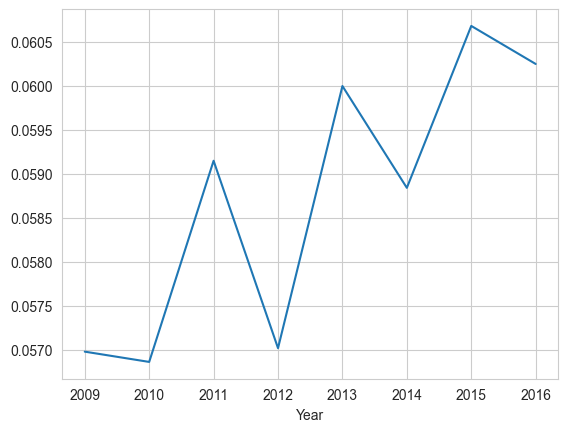

In [1235]:
df.loc[:t_max, 'Total_New_Registrations'].div(df.loc[:t_max, 'Total_Stock']).plot()

<Axes: xlabel='Year'>

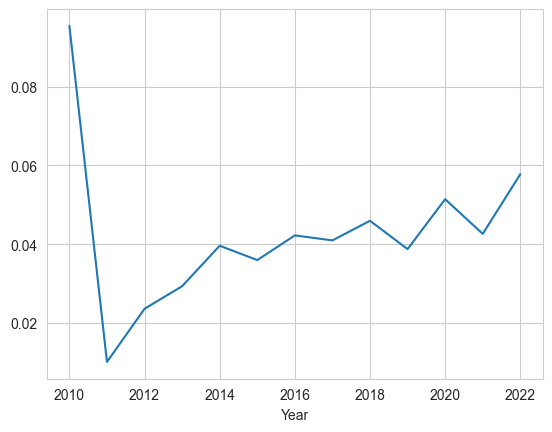

In [1236]:
(df['Total_New_Registrations'] - df['Total_Stock'].diff()).div(df['Total_Stock']).plot()

<Axes: xlabel='Year'>

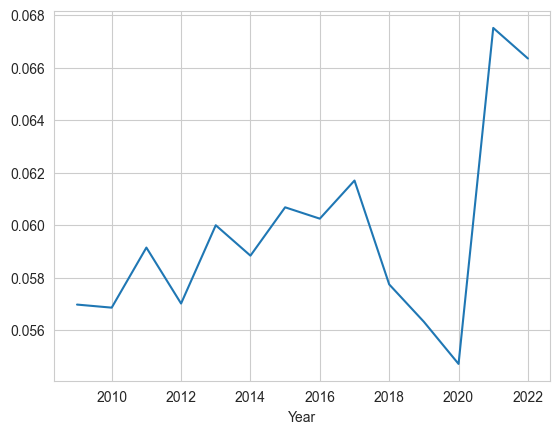

In [1237]:
(df['Total_New_Registrations']).div(df['Total_Stock']).plot()

<Axes: >

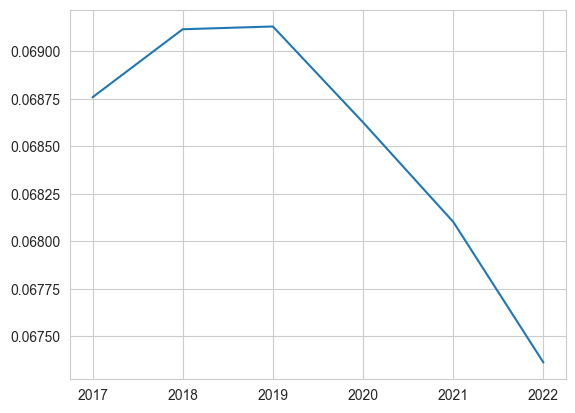

In [1242]:
r_reg_df.median(axis=1).loc[:2022].plot()

<Axes: xlabel='Year'>

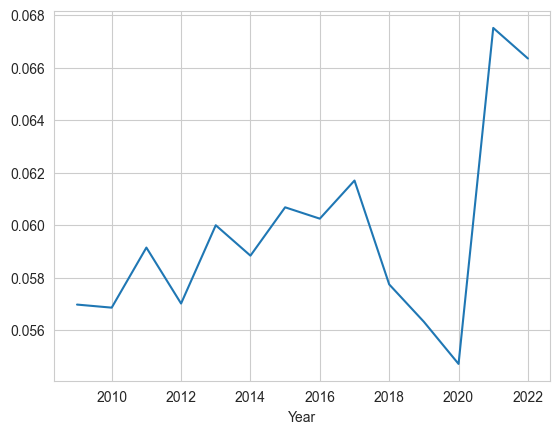

In [1241]:
(df['Total_New_Registrations']).div(df['Total_Stock']).plot()

<Axes: xlabel='Year'>

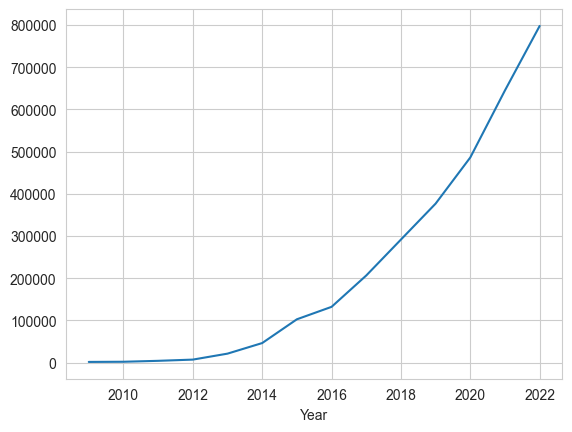

In [1244]:
df['EV_Stock'].plot()

<Axes: xlabel='Year'>

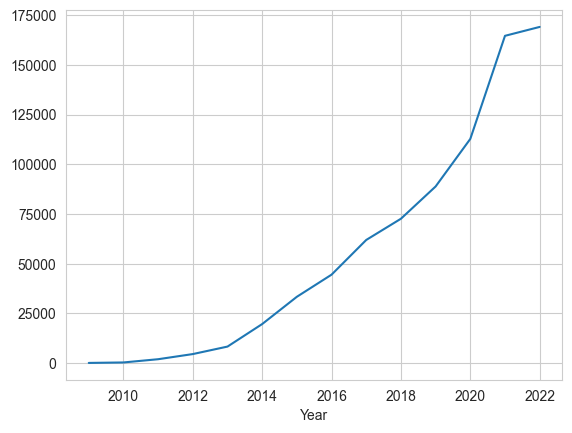

In [1247]:
df['EV_New_Registrations'].plot()

EV Registration Rate

In [1248]:
df['EV_New_Registrations']/df['EV_Stock']

Year
2009    0.104467
2010    0.213244
2011    0.504645
2012    0.667635
2013    0.397642
2014    0.427211
2015    0.326075
2016    0.337443
2017    0.300439
2018    0.249242
2019    0.235904
2020    0.232002
2021    0.255128
2022    0.211895
dtype: float64

In [1298]:
df['EV_New_Registrations']

Year
2009       145
2010       380
2011      2010
2012      4596
2013      8364
2014     19697
2015     33408
2016     44530
2017     61980
2018     72650
2019     88873
2020    112789
2021    164618
2022    169094
Name: EV_New_Registrations, dtype: int64

In [1335]:
df['EV_New_Registrations'].cumsum()

Year
2009       145
2010       525
2011      2535
2012      7131
2013     15495
2014     35192
2015     68600
2016    113130
2017    175110
2018    247760
2019    336633
2020    449422
2021    614040
2022    783134
Name: EV_New_Registrations, dtype: int64

In [1324]:
df['EV_Stock']

Year
2009      1388
2010      1782
2011      3983
2012      6884
2013     21034
2014     46106
2015    102455
2016    131963
2017    206298
2018    291484
2019    376734
2020    486155
2021    645237
2022    798010
Name: EV_Stock, dtype: int64

In [1331]:
df['EV_New_Registrations'].shift(-1)

Year
2009       380.0
2010      2010.0
2011      4596.0
2012      8364.0
2013     19697.0
2014     33408.0
2015     44530.0
2016     61980.0
2017     72650.0
2018     88873.0
2019    112789.0
2020    164618.0
2021    169094.0
2022         NaN
Name: EV_New_Registrations, dtype: float64

In [1332]:
df['EV_New_Registrations'].shift(-1)/df['EV_Stock']

Year
2009    0.273775
2010    1.127946
2011    1.153904
2012    1.214991
2013    0.936436
2014    0.724591
2015    0.434630
2016    0.469677
2017    0.352160
2018    0.304898
2019    0.299386
2020    0.338612
2021    0.262065
2022         NaN
dtype: float64

In [1333]:
(df['EV_New_Registrations'].shift(-1)/df['EV_Stock']).shift(1)

Year
2009         NaN
2010    0.273775
2011    1.127946
2012    1.153904
2013    1.214991
2014    0.936436
2015    0.724591
2016    0.434630
2017    0.469677
2018    0.352160
2019    0.304898
2020    0.299386
2021    0.338612
2022    0.262065
dtype: float64

In [1323]:
df['EV_New_Registrations'].cumsum()

Year
2009       145
2010       525
2011      2535
2012      7131
2013     15495
2014     35192
2015     68600
2016    113130
2017    175110
2018    247760
2019    336633
2020    449422
2021    614040
2022    783134
Name: EV_New_Registrations, dtype: int64

In [1319]:
df['EV_New_Registrations'].shift(-1).cumsum() + df['EV_Stock'].iloc[0]

Year
2009      1768.0
2010      3778.0
2011      8374.0
2012     16738.0
2013     36435.0
2014     69843.0
2015    114373.0
2016    176353.0
2017    249003.0
2018    337876.0
2019    450665.0
2020    615283.0
2021    784377.0
2022         NaN
Name: EV_New_Registrations, dtype: float64

In [1309]:
df['EV_New_Registrations'].shift(-1)/df['EV_Stock']

Year
2009    0.273775
2010    1.127946
2011    1.153904
2012    1.214991
2013    0.936436
2014    0.724591
2015    0.434630
2016    0.469677
2017    0.352160
2018    0.304898
2019    0.299386
2020    0.338612
2021    0.262065
2022         NaN
dtype: float64

In [1297]:
df['EV_Stock']

Year
2009      1388
2010      1782
2011      3983
2012      6884
2013     21034
2014     46106
2015    102455
2016    131963
2017    206298
2018    291484
2019    376734
2020    486155
2021    645237
2022    798010
Name: EV_Stock, dtype: int64

In [1339]:
(df['EV_New_Registrations'].shift(-1)/df['EV_Stock']).shift(1)

Year
2009         NaN
2010    0.273775
2011    1.127946
2012    1.153904
2013    1.214991
2014    0.936436
2015    0.724591
2016    0.434630
2017    0.469677
2018    0.352160
2019    0.304898
2020    0.299386
2021    0.338612
2022    0.262065
dtype: float64

In [1336]:
n_ev = np.zeros(len(df['EV_Stock']))

n_ev[0] = df['EV_Stock'].iloc[0]

for i in range(1, len(df['EV_Stock'])):
    n_ev[i] = n_ev[i-1] + n_ev[i-1]*((df['EV_New_Registrations'].shift(-1)/df['EV_Stock']).shift(1)).iloc[i]

In [1337]:
n_ev

array([  1388.        ,   1768.        ,   3762.20875421,   8103.43683213,
        17949.04195471,  34757.17542348,  59941.91746459,  85994.46331105,
       126384.0940107 , 170891.57556592, 222996.14046577, 289758.1308542 ,
       387873.76061211, 489521.87700492])

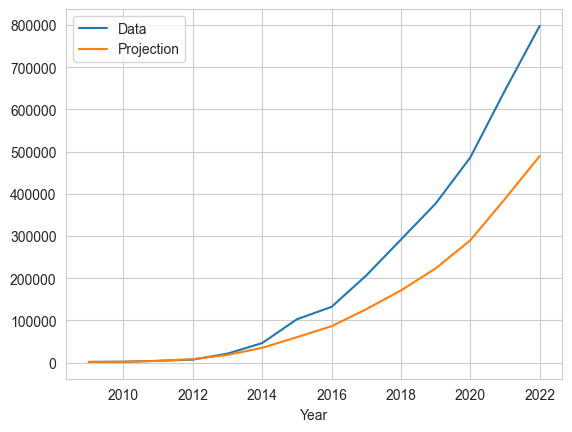

In [1338]:
fig, ax = plt.subplots()

df['EV_Stock'].plot(ax=ax, label='Data')
ax.plot(df['EV_Stock'].index, n_ev, label='Projection')

plt.legend()
plt.show()

ICEV Registration Rate

In [1249]:
df['ICEV_New_Registrations']/df['ICEV_Stock']

Year
2009    0.056953
2010    0.056740
2011    0.058392
2012    0.055282
2013    0.057135
2014    0.052057
2015    0.049855
2016    0.045790
2017    0.042092
2018    0.035051
2019    0.028406
2020    0.017620
2021    0.013353
2022    0.011234
dtype: float64

Total Registration Rate

In [1250]:
df['Total_New_Registrations']/df['Total_Stock']

Year
2009    0.056982
2010    0.056865
2011    0.059151
2012    0.057021
2013    0.060000
2014    0.058843
2015    0.060683
2016    0.060251
2017    0.061701
2018    0.057750
2019    0.056328
2020    0.054724
2021    0.067508
2022    0.066345
dtype: float64

In [1252]:
(df['EV_New_Registrations'] + df['ICEV_New_Registrations']) / (df['EV_Stock'] + df['ICEV_Stock'])

Year
2009    0.056982
2010    0.056865
2011    0.059151
2012    0.057021
2013    0.060000
2014    0.058843
2015    0.060683
2016    0.060251
2017    0.061701
2018    0.057750
2019    0.056328
2020    0.054724
2021    0.067508
2022    0.066345
dtype: float64

In [1246]:
df

Year  BEV_Stock  PHEV_Stock  EV_Stock  ICEV_Stock  Total_Stock  \
Year                                                                   
2009  2009       1388           0      1388   2311945.0    2313333.0   
2010  2010       1782           0      1782   2225718.0    2227500.0   
2011  2011       3982           1      3983   2338370.0    2342353.0   
2012  2012       6543         341      6884   2416449.0    2423333.0   
2013  2013      18000        3034     21034   2478966.0    2500000.0   
2014  2014      39000        7106     46106   2502914.0    2549020.0   
2015  2015      69000       33455    102455   2511181.0    2613636.0   
2016  2016      97532       34431    131963   2529636.0    2661599.0   
2017  2017     138983       67315    206298   2511668.0    2717966.0   
2018  2018     195351       96133    291484   2458957.0    2750441.0   
2019  2019     260692      116042    376734   2422919.0    2799653.0   
2020  2020     340002      146153    486155   2322785.0    2808940.0   
2021  2021     460734      184503    645237   2235405.0    2880642.0   
2022  2022     599169      198841    798010   2107570.0    2905580.0   

      BEV_Stock_Share_Total  PHEV_Stock_Share_Total  EV_Stock_Share_Total  \
Year                                                                        
2009                 0.0006                  0.0000                0.0006   
2010                 0.0008                  0.0000                0.0008   
2011                 0.0017                  0.0000                0.0017   
2012                 0.0027                  0.0001                0.0028   
2013                 0.0072                  0.0012                0.0084   
2014                 0.0153                  0.0028                0.0181   
2015                 0.0264                  0.0128                0.0392   
2016                 0.0366                  0.0130                0.0496   
2017                 0.0511                  0.0248                0.0759   
2018                 0.0710                  0.0349                0.1059   
2019                 0.0931                  0.0414                0.1345   
2020                 0.1171                  0.0411                0.1582   
2021                 0.1550                  0.0591                0.2141   
2022                 0.1676                  0.0614                0.2290   

      ICEV_Stock_Share_Total  ...  EV_New_Registrations  \
Year                          ...                         
2009                  0.9994  ...                   145   
2010                  0.9992  ...                   380   
2011                  0.9983  ...                  2010   
2012                  0.9972  ...                  4596   
2013                  0.9916  ...                  8364   
2014                  0.9819  ...                 19697   
2015                  0.9608  ...                 33408   
2016                  0.9504  ...                 44530   
2017                  0.9241  ...                 61980   
2018                  0.8941  ...                 72650   
2019                  0.8655  ...                 88873   
2020                  0.8418  ...                112789   
2021                  0.7859  ...                164618   
2022                  0.7710  ...                169094   

      ICEV_New_Registrations  Total_New_Registrations  \
Year                                                    
2009                131673.0                 131818.0   
2010                126287.0                 126667.0   
2011                136542.0                 138552.0   
2012                133586.0                 138182.0   
2013                141636.0                 150000.0   
2014                130295.0                 149992.0   
2015                125195.0                 158603.0   
2016                115833.0                 160363.0   
2017                105722.0                 167702.0   
2018                 86189.0                 158

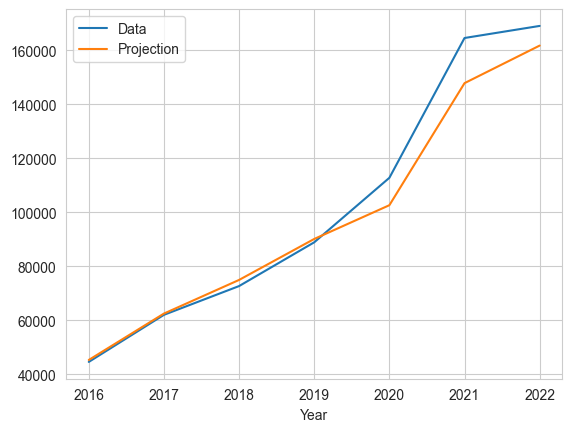

In [1272]:
fig, ax = plt.subplots()
df.loc[t_max:, 'EV_New_Registrations'].plot(ax=ax, label = 'Data')
(ev_share_gp_samples.mean(axis=1).loc[:2022] * df['Total_New_Registrations']).dropna().plot(ax=ax, label="Projection")
plt.legend()
plt.show()

<Axes: title={'center': 'Error'}>

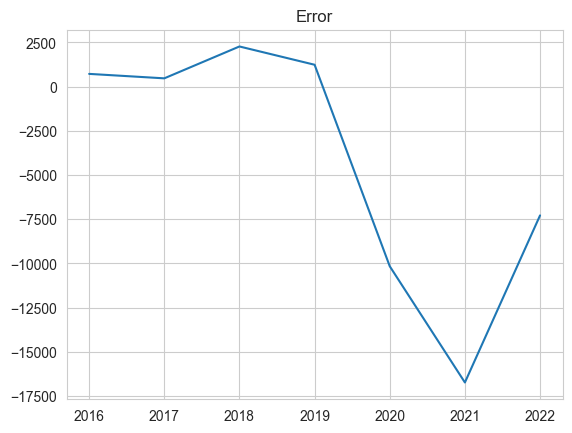

In [1273]:
((ev_share_gp_samples.mean(axis=1).loc[:2022] * df['Total_New_Registrations']).dropna() - df.loc[t_max:, 'EV_New_Registrations']).plot(title='Error')

<Axes: title={'center': 'Percentage Error'}>

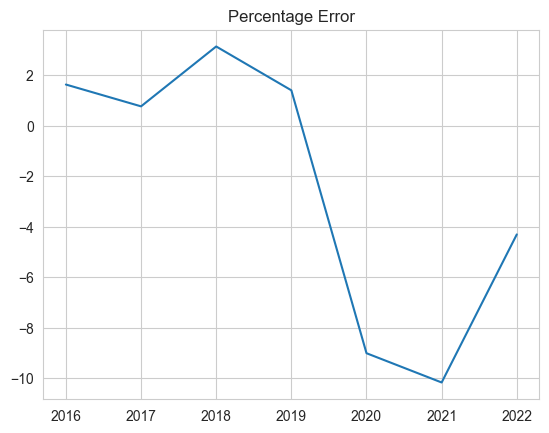

In [1276]:
(100*((ev_share_gp_samples.mean(axis=1).loc[:2022] * df['Total_New_Registrations']).dropna() - df.loc[t_max:, 'EV_New_Registrations'])/df.loc[t_max:, 'EV_New_Registrations']).plot(title='Percentage Error')

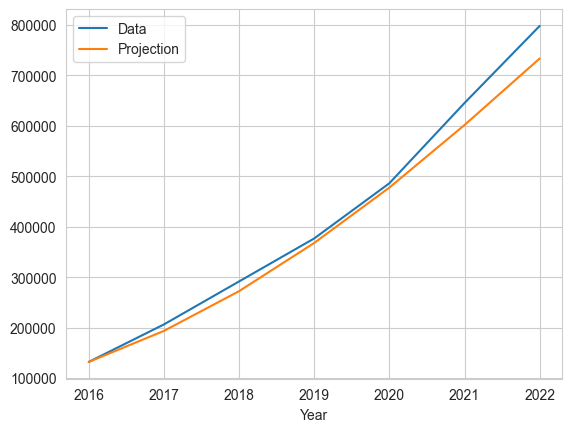

In [1266]:
fig, ax = plt.subplots()
df.loc[t_max:, 'EV_Stock'].plot(ax=ax, label = 'Data')
ev_forecast.quantile(0.5, axis=1).loc[:2022].plot(ax=ax, label="Projection")
plt.legend()
plt.show()

<Axes: title={'center': 'Percentage Error'}>

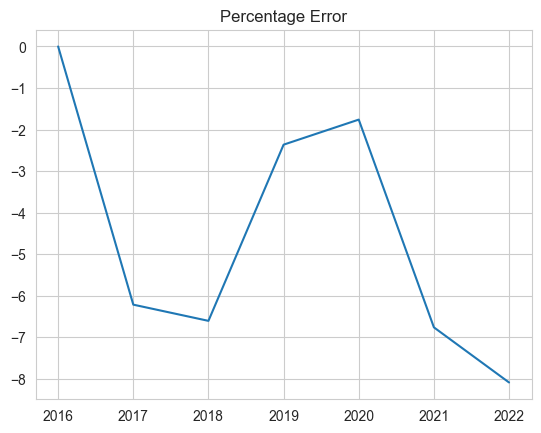

In [1282]:
(100*(ev_forecast.quantile(0.5, axis=1).loc[:2022] - df.loc[t_max:, 'EV_Stock'])/df.loc[t_max:, 'EV_Stock']).plot(title='Percentage Error')

In [1267]:
df.loc[2022, 'EV_Stock'] - ev_forecast.quantile(0.5, axis=1).loc[2022]

64578.25368569896

In [1268]:
(df.loc[2022, 'EV_Stock'] - ev_forecast.quantile(0.5, axis=1).loc[2022])/df.loc[2022, 'EV_Stock']

0.08092411584528886